In [1]:
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline, AutoModelForSequenceClassification
import torch

In [3]:
# Load the dataset
df = pd.read_csv(r"C:\Users\ASUSROG\Downloads\news_excerpts_parsed.csv")

df = df['Text']

In [4]:
df

0       Starbucks violated federal labor law when it i...
1       The first suspect to plead guilty in Singapore...
2       Meta has been fined a record-breaking €1.2 bil...
3       SINGAPORE: A 45-year-old man linked to Singapo...
4       The Department of Education imposed a record $...
                              ...                        
1504    NOT A SURPRISE FOR INDUSTRY FOLLOWERS\n\nIt is...
1505    Ahead of the Tokyo 2020 Olympics, Japan prohib...
1506    At a court hearing on Monday in the city of Ki...
1507    Ray Mann, managing director of the West Wales ...
1508    "These changes will also strengthen laws gover...
Name: Text, Length: 1509, dtype: object

In [18]:
texts = df.dropna().tolist()

In [19]:
texts

['Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.\n\nThe decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.\n\n“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”',
 "The first suspect to plead guilty in Singapore's largest money laundering case was convicted and sentenced to 13 months' jail in a district court on Tuesday (Apr 2).\n\nSu Wenqiang, 32, admitted to 11 charges of money laundering, possessing proceeds from illegal remote gambling offences and lying to get work

In [22]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Extract named entities
entities = []
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))

# Convert to DataFrame for analysis
entities_df = pd.DataFrame(entities, columns=["Entity", "Type"])
#print(entities_df.head())
entities_df

,Entity,Type
0,National Labor Relations Board,ORG
1,Thursday,DATE
2,NLRB,ORG
3,Starbucks,ORG
4,Board,ORG
...,...,...
21318,the past weekend,DATE
21319,"30,000",MONEY
21320,first,ORDINAL
21321,Bloomberg,ORG


      Entity1 Relation    Entity2
0    violated    nsubj  Starbucks
1    violated     dobj        law
2   increased    nsubj         it
3   increased     dobj      wages
4     offered     dobj      perks
5       found    nsubj      judge
6          is    nsubj   decision
7    violated    nsubj  Starbucks
8    violated     dobj        law
9        stop     dobj     unions
10         is    nsubj      issue


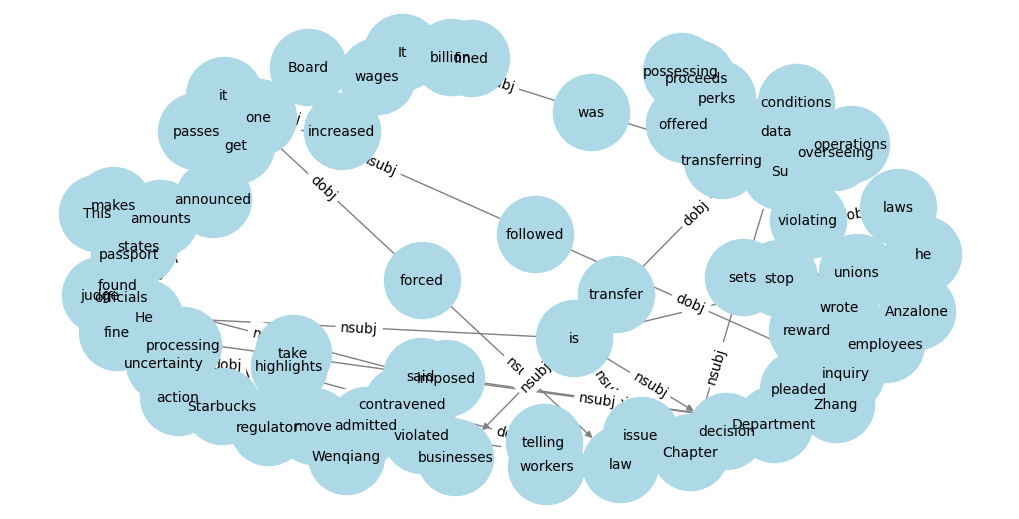

In [27]:
# Extract entity pairs and relationships
relations = []
for text in texts:
    doc = nlp(text)
    for token in doc:
        if token.dep_ in ("nsubj", "dobj"):  # Subject-object relationships
            head = token.head.text
            tail = token.text
            relation = token.dep_
            relations.append((head, relation, tail))

relations = relations[:50]
            
# Convert to DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])
print(relations_df[:11])

# Create a relationship graph
G = nx.DiGraph()
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


terrible graph but entity and relationship extraction is more impt

         Entity1 Relation                           Entity2
0       violated    nsubj                         Starbucks
1       violated     dobj                 federal labor law
2      increased    nsubj                                it
3      increased     dobj                             wages
4        offered     dobj                         new perks
...          ...      ...                               ...
22394        saw     dobj                          S$39,632
22395  regulated    nsubj                               MAS
22396  regulated     dobj  cryptocurrency service providers
22397  possessed    nsubj                              they
22398  possessed     dobj                             money

[22399 rows x 3 columns]


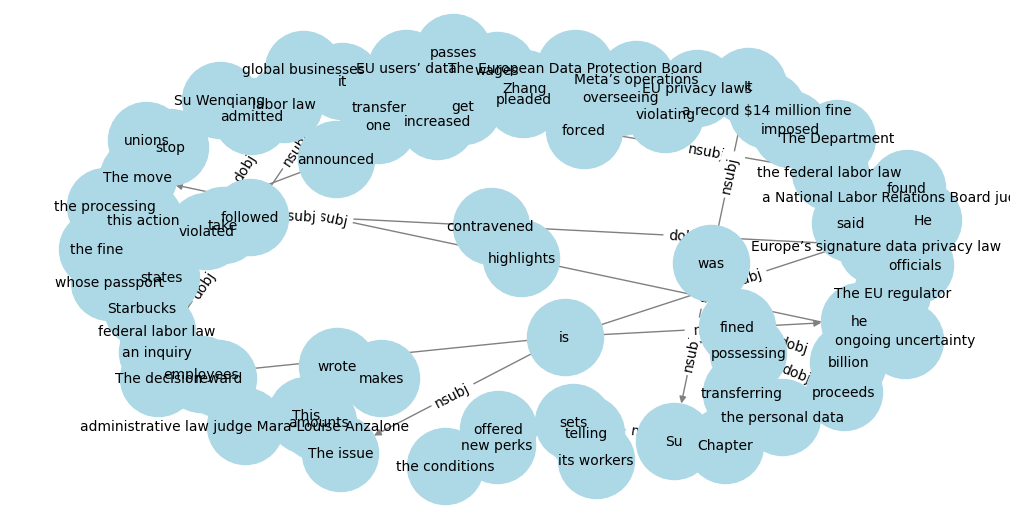

In [30]:
def get_noun_phrases(doc):
    noun_phrases = {chunk.root: chunk.text for chunk in doc.noun_chunks}  # Mapping root words to full phrases
    return noun_phrases

relations = []

# Process each text
for text in texts:
    doc = nlp(text)

    # Get noun phrases (e.g., "federal law" instead of just "law")
    noun_phrases = get_noun_phrases(doc)

    for token in doc:
        # Identify subject-object pairs (Who did what to whom?)
        if token.dep_ in ("nsubj", "dobj"):  # Subject-Object dependency
            head = token.head.text  # The main verb (action word)
            entity = noun_phrases.get(token, token.text)  # Use full noun phrase if available
            relation = token.dep_  # Relationship type (nsubj/dobj)
            relations.append((head, relation, entity))

# Convert extracted relationships to a DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])

# Display results
print(relations_df)

# Create a directed graph
G = nx.DiGraph()

relations = relations[:50]

# Add edges for each relationship
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)  # Position nodes using a layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)

# Add labels to edges
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

NEED MORE PREPROCESSING

         Entity1 Relation                           Entity2
0       violated    nsubj                         Starbucks
1       violated     dobj                 federal labor law
2      increased    nsubj                                it
3      increased     dobj                             wages
4        offered     dobj                         new perks
...          ...      ...                               ...
22394        saw     dobj                          S$39,632
22395  regulated    nsubj                               MAS
22396  regulated     dobj  cryptocurrency service providers
22397  possessed    nsubj                              they
22398  possessed     dobj                             money

[22399 rows x 3 columns]


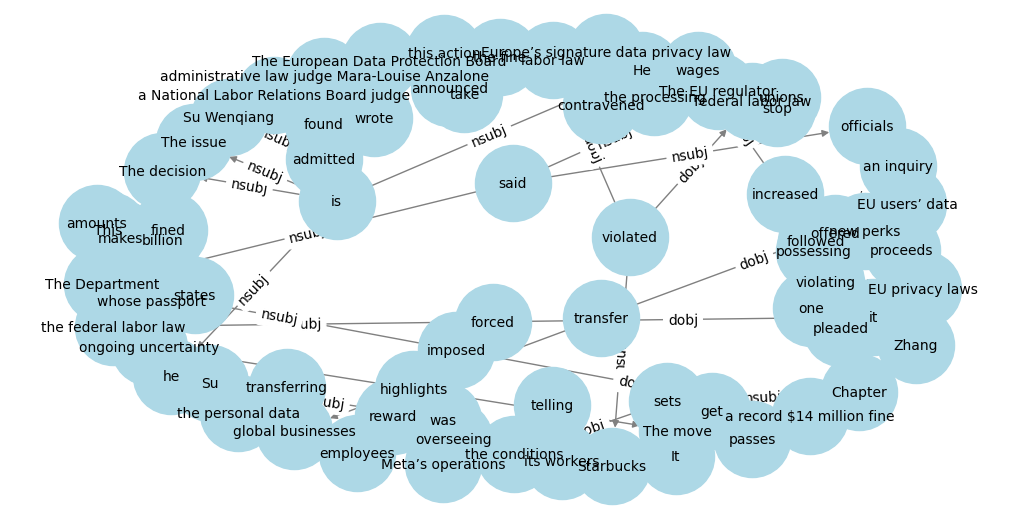

In [31]:
def get_noun_phrases(doc):
    noun_phrases = {chunk.root: chunk.text for chunk in doc.noun_chunks}  # Mapping root words to full phrases
    return noun_phrases

# Function to merge proper nouns joined by "and"
def merge_proper_nouns(doc):
    tokens = list(doc)
    merged_tokens = []
    i = 0

    while i < len(tokens):
        token = tokens[i]

        # If the token is a proper noun and followed by "and" + another proper noun
        if token.pos_ == "PROPN" and i + 2 < len(tokens) and tokens[i + 1].text.lower() == "and" and tokens[i + 2].pos_ == "PROPN":
            merged_entity = f"{token.text} and {tokens[i + 2].text}"
            merged_tokens.append(merged_entity)
            i += 3  # Skip the next two tokens ("and" and the second proper noun)
        else:
            merged_tokens.append(token.text)
            i += 1

    return merged_tokens

# List to store extracted relationships
relations = []

# Process each text
for text in texts:
    doc = nlp(text)

    # Get noun phrases (e.g., "federal law" instead of just "law")
    noun_phrases = get_noun_phrases(doc)

    # Merge proper nouns with "and"
    merged_tokens = merge_proper_nouns(doc)

    for token in doc:
        # Identify subject-object pairs (Who did what to whom?)
        if token.dep_ in ("nsubj", "dobj"):  # Subject-Object dependency
            head = token.head.text  # The main verb (action word)
            entity = noun_phrases.get(token, token.text)  # Use full noun phrase if available

            # Replace entity if it appears in the merged list
            if entity in merged_tokens:
                entity = merged_tokens[merged_tokens.index(entity)]

            relation = token.dep_  # Relationship type (nsubj/dobj)
            relations.append((head, relation, entity))

# Convert extracted relationships to a DataFrame
relations_df = pd.DataFrame(relations, columns=["Entity1", "Relation", "Entity2"])

# Display results
print(relations_df)

# Create a directed graph
G = nx.DiGraph()

relations = relations[:50]

# Add edges for each relationship
for entity1, relation, entity2 in relations:
    G.add_edge(entity1, entity2, label=relation)

# Draw the graph
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(G)  # Position nodes using a layout
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)

# Add labels to edges
edge_labels = {(e1, e2): rel for e1, rel, e2 in relations}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [32]:
relations_df[:20]

,Entity1,Relation,Entity2
0,violated,nsubj,Starbucks
1,violated,dobj,federal labor law
2,increased,nsubj,it
3,increased,dobj,wages
4,offered,dobj,new perks
5,found,nsubj,a National Labor Relations Board judge
6,is,nsubj,The decision
7,violated,nsubj,Starbucks
8,violated,dobj,labor law
9,stop,dobj,unions


In [35]:
# Load Hugging Face model for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Load NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)


texts1 = text1[:50]
# Extract named entities
for text in texts1:
    ner_results = ner_pipeline(text)
    print(f"\nText: {text}")
    for entity in ner_results:
        print(f"{entity['word']} - {entity['entity']} (Score: {entity['score']:.2f})")

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

C:\Users\ASUSROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUSROG\.cache\huggingface\hub\models--dbmdz--bert-large-cased-finetuned-conll03-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Text: Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.

The decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.

“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”
Star - I-ORG (Score: 1.00)
##bu - I-ORG (Score: 1.00)
##cks - I-ORG (Score: 1.00)
National - I-ORG (Score: 1.00)
Labor - I-ORG (Score: 1.00)
Relations - I-ORG (Score: 1.00)
Board - I-ORG (Score: 1.00)
NL - I-ORG (Score: 0.99)
##RB - I-ORG (Score: 1.00)
Star - I-ORG (Score: 1.00)
##bu - I-ORG (Score: 1.00)
##cks


Text: On Thursday, the Brussels Criminal Court’s prosecutor, requested 20-year prison sentences for Alfredo H. and Indrit K. in the Black Eagle case, related to a large drug trafficking operation.

She identified these two Albanian nationals as the leaders of the criminal organisation responsible for the drug trafficking operation. Prosecution evidence includes cocaine seizures conducted throughout the investigation launched in 2020, with an estimated value of €13.42 million.

Alfredo H., pinpointed as one of the operation’s heads, was found to have connections with Italian mafia groups established in Limburg and heads of a larger organisation based in Majorca. "They implemented modern business methods, sharing resources, workforce, and equipment," explained the prosecutor.
Brussels - I-ORG (Score: 0.97)
Criminal - I-ORG (Score: 0.98)
Court - I-ORG (Score: 0.98)
Alfredo - I-PER (Score: 1.00)
H - I-PER (Score: 1.00)
. - I-PER (Score: 0.74)
In - I-PER (Score: 1.00)
##dr - I-PER (Score: 


Text: The Helsinki District Court has handed down several lengthy prison sentences in a wide-ranging narcotics network case with 23 defendants and almost 70 charges.

Most of the verdicts were given for serious drug offences committed between 2019 and 2021 in different parts of the Helsinki metropolitan area.

A total of 16 defendants received prison sentences, while three received suspended sentences.

According to the court, the drug ring trafficked considerable quantities of illegal narcotics into Finland. Estimates by the police place the street value of the drugs to be at about six million euros.

The district court sentenced Teemu Juhani Kirves— the head of a Sweden-based drug syndicate — to four years in prison for several aggravated narcotics offences.
Helsinki - I-ORG (Score: 0.58)
District - I-ORG (Score: 0.78)
Court - I-ORG (Score: 0.94)
Helsinki - I-LOC (Score: 1.00)
Finland - I-LOC (Score: 1.00)
Te - I-PER (Score: 1.00)
##em - I-PER (Score: 0.97)
##u - I-PER (Score: 1.00)


Text: Two 10-year-old children were found working at a Louisville McDonald’s restaurant — sometimes until 2 a.m. — the US Department of Labor said Tuesday.

The revelation was part of an investigation into the child labor law violations in the Southeast. The agency also found three franchisees that own more than 60 McDonald’s locations in Kentucky, Indiana, Maryland and Ohio, “employed 305 children to work more than the legally permitted hours and perform tasks prohibited by law for young workers,” the Labor Department said in a statement.

“Investigators from the department’s Wage and Hour Division found two 10-year-old workers at a Louisville McDonald’s restaurant among many violations of federal labor laws committed by three Kentucky McDonald’s franchise operators,” the release said. “Investigators also determined two 10-year-old children were employed – but not paid – and sometimes worked as late as 2 a.m.”
Louisville - I-LOC (Score: 0.97)
McDonald - I-ORG (Score: 1.00)
’ - I-ORG 


Text: A British man long suspected of killing the wife of a famous French film producer in Ireland has died at age 66, according to his lawyer.

Back in 2019, the Paris Criminal Court convicted Ian Bailey in absentia of the murder of TV producer Sophie Toscan du Plantier and sentenced him to 25 years’ imprisonment.

Bailey, a former journalist, had denied involvement in the murder, which has been the subject of a popular podcast series and two TV documentaries, including one on Netflix.

On December 23, 1996, 39-year-old Toscan du Plantier was found bludgeoned to death near the gate of her vacation home near Toormore, in Ireland’s West Cork region. Police found some 50 wounds on her body.
British - I-MISC (Score: 1.00)
French - I-MISC (Score: 1.00)
Ireland - I-LOC (Score: 1.00)
Paris - I-ORG (Score: 0.91)
Criminal - I-ORG (Score: 0.96)
Court - I-ORG (Score: 0.97)
Ian - I-PER (Score: 1.00)
Bailey - I-PER (Score: 1.00)
Sophie - I-PER (Score: 1.00)
To - I-PER (Score: 1.00)
##sca - I-PER 


Text: Swedish climate activist Greta Thunberg was charged with disobeying a police order on Friday (Sep 15), less than two months after she was convicted and fined for the same offence.

Thunberg, 20, was fined 1,500 Swedish crowns (US$134) by a Swedish court on Jul 24 for failing to leave a protest when ordered by police.

Straight after the verdict, Thunberg and other activists from the environmental group Reclaim the Future blocked the road for oil trucks in Malmo harbour and were again forcibly removed by police.

"The demonstration did not have a permit and it led to the blocking of car traffic. The woman refused to obey the police command to leave the scene," the prosecutor said in a statement.
Swedish - I-MISC (Score: 1.00)
G - I-PER (Score: 1.00)
##reta - I-PER (Score: 1.00)
T - I-PER (Score: 1.00)
##hun - I-PER (Score: 1.00)
##berg - I-PER (Score: 1.00)
T - I-PER (Score: 1.00)
##hun - I-PER (Score: 1.00)
##berg - I-PER (Score: 1.00)
Swedish - I-MISC (Score: 1.00)
US - I-MISC 


Text: India's Financial Intelligence Unit (FIU) on Friday imposed a penalty of 54.9 million rupees ($662,565) on Paytm's (PAYT.NS), opens new tab banking arm, Paytm Payments Bank, for violations in reporting illegal money routed through its accounts, the country's finance ministry said.

The FIU initiated a review of Paytm Payments Bank after information from law enforcement agencies about some entities engaged in illegal acts, including organising and facilitating online gambling, and routing proceeds through the bank.

"The money generated from these illegal operations, i.e. proceeds of crime, were routed and channelled through bank accounts maintained by these entities with the Paytm Payments Bank," the ministry said in a statement.
The payments bank failed to report suspicious transactions and conduct due diligence of these accounts, the FIU's order said.

Based on the "voluminous" material available on record, it found that the charges against Paytm Payments Bank were substantiat


Text: Burger & Lobster Singapore was fined $3,000 by the courts on April 11 for food safety lapses, the Singapore Food Agency (SFA) said in a statement.

In May 2022, SFA received reports of gastroenteritis involving 132 people who ate at the Burger & Lobster outlet in Jewel Changi Airport between May 7 and 15 in 2022.

Five of them were hospitalised.

The SFA and the Ministry of Health found multiple lapses. These included poor housekeeping, cracked kitchen floor tiles, using a dirty oven toaster and failure to employ a food hygiene officer for the premises.

In the interest of public health, SFA suspended their food business operations from May 16 to July 5 in 2022, and it directed Burger & Lobster Singapore to take necessary measures to improve food safety practices and the cleanliness of its premises.
Burger - I-ORG (Score: 1.00)
& - I-ORG (Score: 1.00)
Lo - I-ORG (Score: 1.00)
##bs - I-ORG (Score: 1.00)
##ter - I-ORG (Score: 1.00)
Singapore - I-ORG (Score: 1.00)
Singapore - I-ORG


Text: The Consumer Financial Protection Bureau (CFPB) and Federal Trade Commission (FTC) fined credit reporting agency TransUnion a total of $23 million over inaccurate rental background checks and poor handling of consumer credit report locks and freezes, the agencies said on Thursday.

TransUnion will pay $15 million and make "significant improvements to how it reports evictions," the CFPB said. Separately, the CFPB is ordering TransUnion to pay $8 million "for lying to consumers" about requested security freezes and locks requested by tens of thousands of consumers.

While telling the consumers their requests had been processed, the company allegedly put them instead into a "yearslong backlog," according to the CFPB.
Consumer - I-ORG (Score: 1.00)
Financial - I-ORG (Score: 1.00)
Protection - I-ORG (Score: 1.00)
Bureau - I-ORG (Score: 1.00)
CF - I-ORG (Score: 1.00)
##P - I-ORG (Score: 1.00)
##B - I-ORG (Score: 1.00)
Federal - I-ORG (Score: 1.00)
Trade - I-ORG (Score: 1.00)
Commissio


Text: Six Italian energy providers including Eni's unit PlenitudeENI.MI and Enel ENEI.MI have been fined more than 15.6 million euros ($16.31 million) for raising charges during a ban on unilateral price hikes, Italy's antitrust agency (AGCM) said.

The billing took place between August 2022 and June 2023, when the government banned unilateral price increases for gas and electricity supplies, AGCM said in a press release on Wednesday.

Enel was ordered to pay the maximum fine of 10 million euros while Eni was ordered to pay 5 million euros for raising prices for more than 4 million customers without any advance warning.

Regional utilities Acea ACE.MI and Dolomiti Energia were fined 560,000 euros and 50,000 euros respectively for giving customers insufficient advance notice of their price increases.
Italian - I-MISC (Score: 1.00)
En - I-ORG (Score: 1.00)
##i - I-ORG (Score: 1.00)
P - I-ORG (Score: 1.00)
##len - I-ORG (Score: 0.99)
##itude - I-ORG (Score: 1.00)
##EN - I-ORG (Score: 1.0


Text: The European Union on Tuesday (Nov 8) imposed sanctions on several senior officials and armed forces officers in Myanmar, where a military takeover last year set off violence that threatens to destabilise other parts of Southeast Asia.

The EU froze the assets of 19 people – including Investment and Foreign Economic Relations Minister Kan Zaw and the chief justice at Myanmar’s supreme court, top military brass and businesspeople linked to the armed forces – and banned them from traveling in Europe.

The 27-nation bloc also froze the assets in Europe of Myanmar’s State Administration Council. EU headquarters said in a statement that the SAC, set up in February 2021 following a military coup, “is responsible for policies and activities that undermine democracy and the rule of law”.
European - I-ORG (Score: 1.00)
Union - I-ORG (Score: 1.00)
Myanmar - I-LOC (Score: 1.00)
Southeast - I-LOC (Score: 1.00)
Asia - I-LOC (Score: 0.99)
EU - I-ORG (Score: 1.00)
and - I-ORG (Score: 0.66)
For


Text: The United States issued new sanctions against Belarus on Wednesday (Aug 9), the Treasury Department said, adding it was designating eight individuals and five entities to a list for allegedly funding the Belarusian government.

"This action targets several entities involved in the Belarusian regime’s continued civil society repression, complicity in the Russian Federation’s unjustified war in Ukraine, and enrichment of repressive Belarusian regime leader" Alexander Lukashenko, the Treasury Department said in a statement.

Lukashenko has repeatedly accused the West of trying to topple him after mass protests against his rule erupted in 2020 in the wake of a presidential election the opposition said he had fraudulently won. Lukashenko said he had won fairly, while conducting a sweeping crackdown on his opponents.
United - I-LOC (Score: 1.00)
States - I-LOC (Score: 1.00)
Belarus - I-LOC (Score: 1.00)
Treasury - I-ORG (Score: 1.00)
Department - I-ORG (Score: 1.00)
Belarusian - I-MI


Text: Singapore has joined over 30 other countries in issuing sanctions against Russia in protest of its invasion of Ukraine. They prohibit certain financial and business transactions with the Russian government and with certain Russian entities and individuals. 

While the point of sanctions is to put pressure on Russia to stop the war, will they have the desired effect?  

About a month after sanctions were first implemented, amidst a striking breakdown of diplomatic relations, Russia made the veiled statement – which only served to escalate tensions – that it would only use nuclear weapons if its existence is threatened.  

It’s not clear whether the sanctions can motivate Russia to come to an amicable resolution of the conflict. What is clear, however, is that sanctions often come at an economic cost to the countries imposing them. 
Singapore - I-LOC (Score: 1.00)
Russia - I-LOC (Score: 1.00)
Ukraine - I-LOC (Score: 1.00)
Russian - I-MISC (Score: 1.00)
Russian - I-MISC (Score: 1.0


Text: Taiwan will take part in the Asia-Pacific Economic Cooperation forum in San Francisco this week (Nov 13 -17), a rare opportunity for the self-governing island democracy of 23 million people and its high-tech economy to break the diplomatic embargo on it imposed by authoritarian China.

Taiwan's chief delegate will be a civilian rather than a government figure or head of state, under an unwritten rule that satisfies China’s contention that members of the organization participate as economic entities rather than state players.

For the seventh time, Taiwan will be represented by Morris Chang, the 92-year-old founder of the world-leading Taiwan Semiconductor Manufacturing Company. Chang is known as the godfather of the industry that has put Taiwan in the top ranks of high-tech manufacturing and personal electronic devices.
Taiwan - I-LOC (Score: 1.00)
Asia - I-MISC (Score: 0.89)
- - I-ORG (Score: 0.73)
Pacific - I-ORG (Score: 0.70)
Economic - I-ORG (Score: 0.85)
Cooperation - I-ORG


Text: Grossi was met with angry protests by civic groups as he arrived in South Korea on Friday from Japan and drew street rallies on Saturday criticising the plan.

South Korea's government said on Friday it respected the IAEA's report and that its own analysis had found the release will not have "any meaningful impact" on its waters.

Chinese foreign ministry spokesman Wang Wenbin on Wednesday criticised the move towards discharging the water and threatened action if the plan should move ahead.

North Korea also criticised IAEA's backing of Japan's plan, calling it "unjust" and a demonstration of double standards, citing the UN nuclear watchdog's work to curb Pyongyang's nuclear programme.

North Korea has faced UN Security Council sanctions for its six underground nuclear tests. 
Gross - I-PER (Score: 1.00)
##i - I-PER (Score: 0.98)
South - I-LOC (Score: 1.00)
Korea - I-LOC (Score: 1.00)
Japan - I-LOC (Score: 1.00)
South - I-LOC (Score: 1.00)
Korea - I-LOC (Score: 1.00)
I - I-ORG (


Text: The Iranians were not totally unscathed, however. Washington has announced sanctions against senior members of the Islamic Revolutionary Guards Corps, as well as criminal charges against several people who had a direct role in funding Hamas and Hezbollah. The effects of these actions are negligible, however. Iran has long been under wide-ranging strictures, and the latest moves are unlikely to make things much worse for it.

What remains to be seen is whether both sides will decide that enough is enough, after all is said and done.

Iran will have to tread even more carefully now after the latest round of strikes. It must know that despite the latest US action, pressure is mounting on Mr Biden to do more.
Iranian - I-MISC (Score: 1.00)
Washington - I-LOC (Score: 1.00)
Islamic - I-ORG (Score: 1.00)
Revolutionary - I-ORG (Score: 1.00)
Guards - I-ORG (Score: 1.00)
Corps - I-ORG (Score: 1.00)
Hamas - I-ORG (Score: 1.00)
He - I-ORG (Score: 1.00)
##z - I-ORG (Score: 0.97)
##bol - I-OR


Text: In 2019, Japan’s government tightened export controls on three materials to South Korea — fluorinated polyimide, hydrogen fluoride and resists — key materials used in the production of semiconductors. The two countries are also discussing restoring each other’s trade status.

The South Korean trade ministry also said it plans to revise government export regulations to restore Japan’s status as a favored trade destination for the export of “strategic” materials that can be used for both civilian and military purposes.

The South Korean ministry said it will continue to engage in broader talks with its Japanese counterparts to discuss both countries restoring their “white lists” of nations enjoying minimum trade restrictions, after Tokyo and Seoul downgraded each other’s trade status during the 2019 dispute.
Japan - I-LOC (Score: 1.00)
South - I-LOC (Score: 1.00)
Korea - I-LOC (Score: 1.00)
South - I-MISC (Score: 1.00)
Korean - I-MISC (Score: 1.00)
Japan - I-LOC (Score: 1.00)
Sout


Text: Australia was among a host of countries that imposed fresh sanctions on Myanmar on February 1, the third anniversary of the military coup. The government added five businesses to its list of 16 individuals sanctioned since 2021.

Australia has targeted two banks that help fund Myanmar’s junta and its arms purchases, the Myanma Foreign Trade Bank and Myanma Investment and Commercial Bank. The sanctions also target three other entities, Asia Sun Group, Asia Sun Trading Co Ltd, and Cargo Link Petroleum Logistics Co Ltd, for their role in supplying jet fuel to the security forces: the same fuel that the military has used to carry out unlawfully indiscriminate airstrikes against civilians.
Australia - I-LOC (Score: 1.00)
Myanmar - I-LOC (Score: 1.00)
Australia - I-LOC (Score: 1.00)
Myanmar - I-LOC (Score: 1.00)
My - I-ORG (Score: 1.00)
##an - I-ORG (Score: 1.00)
##ma - I-ORG (Score: 1.00)
Foreign - I-ORG (Score: 1.00)
Trade - I-ORG (Score: 1.00)
Bank - I-ORG (Score: 1.00)
My - I-ORG 


Text: Australian Foreign Minister Senator Penny Wong announced additional sanctions against the Myanmar military regime on the third anniversary of the Myanmar coup last week. This move follows several months of robust advocacy efforts, notably highlighted by an open letter initiated by the Australian-based Myanmar Campaign Network (MCN) and addressed to the Foreign Minister in early November 2023.

The letter, endorsed by over 400 organizations, including UNI Global Union, identified more than 20 state-owned enterprises and entities within the banking sector that significantly contribute to the junta’s ability to finance its oppressive activities against the people of Myanmar.

Among the identified entities, the Australian government has chosen to impose sanctions specifically on the state-owned Myanma Foreign Trade Bank (MFTB) and Myanma Investment and Commercial Bank (MICB). Three jet fuel suppliers were also included in the new sanctions.
Australian - I-MISC (Score: 1.00)
Penny - 


Text: In February U.S. authorities imposed additional sweeping sanctions against Russia, including on its National Payment Card System (NSPK), which operates Mir cards.

"Starting April 3, 2024, adding and using Mir cards in Samsung Pay will not be available," Samsung Pay said in a statement on its website.

"At the same time, the functionality of adding and using club cards/loyalty cards in the Samsung Pay app will work unchanged."

Samsung Pay said its services would continue to operate in Belarus, which has also come under heavy Western sanctions.

The NSPK confirmed that the use of Mir cards in the Samsung Pay application would be suspended from April 3.
U - I-LOC (Score: 1.00)
S - I-LOC (Score: 1.00)
Russia - I-LOC (Score: 1.00)
National - I-MISC (Score: 0.93)
Pay - I-MISC (Score: 0.52)
##ment - I-MISC (Score: 0.87)
Card - I-MISC (Score: 0.79)
System - I-MISC (Score: 0.87)
N - I-MISC (Score: 0.70)
##SP - I-MISC (Score: 0.46)
##K - I-ORG (Score: 0.45)
Mir - I-MISC (Score: 0.99)
Mi


Text: The UN said on Tuesday (Mar 19) that Israel's severe restrictions on aid into war-ravaged Gaza coupled with its military offensive could amount to using starvation as a "weapon of war", which would be a "war crime".

United Nations human rights chief Volker Turk denounced the rampant hunger and looming famine in Gaza.

In a statement slammed by Israel, Turk said that "the situation of hunger, starvation and famine is a result of Israel's extensive restrictions on the entry and distribution of humanitarian aid and commercial goods".

It was also linked to the "displacement of most of the population, as well as the destruction of crucial civilian infrastructure", he said.
UN - I-ORG (Score: 1.00)
Israel - I-LOC (Score: 1.00)
Gaza - I-LOC (Score: 1.00)
United - I-ORG (Score: 1.00)
Nations - I-ORG (Score: 1.00)
Vol - I-PER (Score: 1.00)
##ker - I-PER (Score: 1.00)
Tu - I-PER (Score: 1.00)
##rk - I-PER (Score: 1.00)
Gaza - I-LOC (Score: 1.00)
Israel - I-LOC (Score: 1.00)
Tu - I-PER (


Text: Following a push for cultural assimilation by the Thai government in the early 1930s and the introduction of Thai-centric practices, separatist movements were born among the ethnic Malay Patani, who found themselves struggling to preserve their lifestyle and traditions. Ever since, calls have been made for autonomy from the Thai state amid clashes between militants and Thai officers.

The violence remained relatively low key until 2004, when a group of insurgents broke into an army camp in Narathiwas and stole hundreds of firearms.

“The situation then was violent. People died every day and bomb attacks were constant. There was a lot of distrust among local civilians,” said Captain Boonsiang Kaewkoonjob from the Fourth Army – a military division that controls southern Thailand.
Thai - I-MISC (Score: 1.00)
Thai - I-MISC (Score: 1.00)
Malay - I-MISC (Score: 0.99)
Pat - I-ORG (Score: 0.42)
##ani - I-MISC (Score: 0.46)
Thai - I-MISC (Score: 1.00)
Thai - I-MISC (Score: 1.00)
Na - I-L


Text: Large areas of Jamaica's capital, Kingston, were barricaded against security forces last night as four people were killed during violence orchestrated by supporters of one of the country's gang leaders, who is wanted for extradition by the US.

The government declared a state of emergency on Sunday after supporters of Christopher "Dudus" Coke, who is wanted in the US for drug and weapons trafficking, attacked four police stations in the city, burning one to the ground. At least two police officers, one soldier and one civilian have been killed and several others wounded during two days of violence.

Last night, automatic rifle fire continued after dark and sections of the city remained barricaded off, with army trucks attempting to clear roadblocks in the Red Hills district.
Jamaica - I-LOC (Score: 1.00)
Kingston - I-LOC (Score: 1.00)
US - I-LOC (Score: 1.00)
Christopher - I-PER (Score: 1.00)
Du - I-PER (Score: 1.00)
##dus - I-PER (Score: 1.00)
" - I-PER (Score: 0.81)
Coke - I-P


Text: Between 2006-09, attacks perpetrated by Tompolo's Movement for the Emancipation of the Niger Delta (MEND) saw oil production in Nigeria cut by a third, with dozens of foreign office workers being taken hostage and killed. Tompolo claims to have changed his ways, but at present he is wanted by the Nigerian Economic and Financial Crimes Commission for charges of money laundering, conspiracy and theft.

Despite the bounty on his head, he is linked to a number of businesses—including some that enjoy government contracts. One of those companies, Global West Vessel Specialist (GWVS), was at the heart of an £8.1 million deal ($10.4 million) to buy seven former gunships—including the 2,530-tonne KNM Horten—from Norway via the U.K.-based CAS-Global. The deal, which took place in 2014, is the subject of a major new report by campaign group Corruption Watch.
Tom - I-PER (Score: 1.00)
##pol - I-PER (Score: 0.99)
##o - I-PER (Score: 0.99)
Movement - I-ORG (Score: 1.00)
for - I-ORG (Score: 1.


Text: "The village of Nzakoundou was the target of a deadly attack attributed to 3R armed elements on December 21, killing 23 civilians", announced the UN in a press release, adding that the village had been burnt down and the rest of the population "fled into the bush".

The blue helmets of the UN Mission in the Central African Republic (Minusca), whose number was not specified, "are progressing towards the village" with the aim of "reinforcing security in the area and facilitating humanitarian access to the population", the UN mission explained.

The 3R armed group (Return, Reclamation and Rehabilitation) is one of the most powerful of a multitude of rebel groups and criminal gangs terrorizing the population in this vast Central African country.
N - I-LOC (Score: 1.00)
##zak - I-LOC (Score: 0.99)
##ou - I-LOC (Score: 0.97)
##ndo - I-LOC (Score: 0.94)
##u - I-LOC (Score: 1.00)
3 - I-ORG (Score: 0.99)
##R - I-ORG (Score: 1.00)
UN - I-ORG (Score: 1.00)
UN - I-ORG (Score: 1.00)
Mission 


Text: The leader of a small but violent left-wing rebel group which has been terrorising rural communities in Paraguay has been killed in a clash with soldiers, officials say.

Osvaldo Villalba was the leader of the Paraguayan People's Army (EPP), which has carried out a string of killings and kidnappings in Paraguay.

Among those being held by the EPP is the country's former Vice-President, Óscar Denis.

He was kidnapped in September 2020.

Army officials told reporters that soldiers had come across the rebels on Sunday after they heard gunshots while on patrol in Amambay province.

When they arrived at the scene of the shooting they found two indigenous people had been killed and a third injured by the rebels.
Paraguay - I-LOC (Score: 1.00)
O - I-PER (Score: 1.00)
##s - I-PER (Score: 0.99)
##val - I-PER (Score: 1.00)
##do - I-PER (Score: 1.00)
Villa - I-PER (Score: 1.00)
##l - I-PER (Score: 0.95)
##ba - I-PER (Score: 0.99)
Paraguay - I-ORG (Score: 1.00)
##an - I-ORG (Score: 1.00)
Pe


Text: What happened once they left?
Local elections were held in East Timor and the two biggest parties – the Revolutionary Front for an Independent East Timor (Fretilin) and the Timorese Democratic Union (UDT) – formed a coalition, but it did not last long. Fighting broke out, there was an attempted coup by UDT, and then Fretilin unilaterally declared independence on 28 November 1975.

What was Indonesia’s reaction?
Indonesian forces had already secretly begun attacks across the border from Indonesian West Timor (on the other side of the island) in October 1975, where five Australian journalists were killed in the town of Balibo. Jakarta feared a communist state on its doorstep and that a newly independent country in its sphere could destabilise the rest of the archipelago. It launched a full-scale invasion of Timor in December 1975.
East - I-LOC (Score: 1.00)
Timor - I-LOC (Score: 1.00)
Revolutionary - I-ORG (Score: 1.00)
Front - I-ORG (Score: 1.00)
for - I-ORG (Score: 1.00)
an - I-


Text: "DUBAI: Yemen's Houthis said on Tuesday (Dec 12) they carried out a military operation against the Norwegian commercial tanker STRINDA in their latest protest against Israel's bombardment of Gaza.

The group said it hit the tanker with a rocket because it was delivering crude oil to an Israeli terminal and after its crew ignored all warnings, Houthi military spokesperson Yehia Sarea said in a statement.

However, the tanker's owner, Norway's Mowinckel Chemical Tankers, said the vessel was headed to Italy with a cargo of palm oil to be used in biofuels. It was not planning to stop in Israel, a company's spokesperson told Reuters.

The STRINDA had loaded vegetable oil and biofuels in Malaysia and was headed for Venice, data from shiptracking firm Kpler showed."
D - I-ORG (Score: 0.51)
##U - I-ORG (Score: 0.54)
##BA - I-ORG (Score: 0.54)
##I - I-ORG (Score: 0.33)
Yemen - I-LOC (Score: 1.00)
Ho - I-ORG (Score: 0.72)
##uth - I-ORG (Score: 0.50)
Norwegian - I-MISC (Score: 1.00)
ST - I


Text: "YEREVAN: Azerbaijan said on Wednesday (Sep 20) it had halted military action in its breakaway region of Nagorno-Karabakh after its battlefield success forced Armenian separatist forces to agree to a ceasefire that will see the area fully return to Baku's control.

Under the agreement, outlined by Azerbaijan and the Russian Defence Ministry, which has peacekeepers on the ground, separatist forces are meant to disband and disarm, while talks on the future of ethnic Armenians who live there are due to start on Thursday.

In a speech to the nation on Wednesday evening, Azerbaijani President Ilham Aliyev said Baku had restored its sovereignty "with an iron fist" in a 24-hour offensive by troops backed by artillery strikes that brought the breakaway region to heel."
Azerbaijan - I-LOC (Score: 1.00)
Na - I-LOC (Score: 1.00)
##gor - I-LOC (Score: 1.00)
##no - I-LOC (Score: 0.98)
- - I-LOC (Score: 0.96)
Kara - I-LOC (Score: 1.00)
##ba - I-LOC (Score: 0.99)
##kh - I-LOC (Score: 1.00)
Arm


Text: "PARIS: France will pull its soldiers out of Niger following a July coup in the West African country, President Emmanuel Macron said on Sunday (Sep 24), dealing a huge blow to French influence and counter-insurgency operations in the Sahel region.

Macron said 1,500 troops would withdraw by the end of the year and that France, the former colonial power in Niger, refused to "be held hostage by the putchists".

France's exit, which comes after weeks of pressure from the junta and popular demonstrations, is likely to exacerbate Western concerns over Russia's expanding influence in Africa. The Russian mercenary force Wagner already present in Niger's neighbour Mali."
France - I-LOC (Score: 1.00)
Niger - I-LOC (Score: 1.00)
West - I-MISC (Score: 1.00)
African - I-MISC (Score: 1.00)
Emmanuel - I-PER (Score: 1.00)
Mac - I-PER (Score: 1.00)
##ron - I-PER (Score: 0.99)
French - I-MISC (Score: 1.00)
Sa - I-LOC (Score: 1.00)
##hel - I-LOC (Score: 1.00)
Mac - I-PER (Score: 1.00)
##ron - I-P


Text: Civil society organisations at the World Trade Organization (WTO) meeting in the United Arab Emirates this week have criticized restrictions on their participation, including alleging that some of their members had been briefly detained at the talks.

Our World Is Not For Sale (OWINFS), a network of civil society groups, said on Wednesday it had complained to WTO Director-General Ngozi Okonjo-Iweala over several incidents of "detainment, confiscation of materials, and heavy-handed restrictions on lobbying by civil society" groups.

The WTO, in a statement, said the director-general had met with civil society representatives on Tuesday to discuss their concerns and had since spoken with the host chair of the talks to identify solutions.
World - I-ORG (Score: 1.00)
Trade - I-ORG (Score: 1.00)
Organization - I-ORG (Score: 1.00)
W - I-ORG (Score: 0.99)
##TO - I-ORG (Score: 1.00)
United - I-LOC (Score: 1.00)
Arab - I-LOC (Score: 1.00)
Emirates - I-LOC (Score: 1.00)
Our - I-ORG (Score


Text: HONG KONG: China on Thursday (Feb 29) criticised British Foreign Secretary David Cameron and other foreign politicians for "smearing" an upcoming Hong Kong security law, as local authorities said feedback on the law had been largely positive.

The law, known as Article 23, will target crimes including treason, theft of state secrets, espionage, sabotage, sedition and "external interference", including from foreign governments.

A public consultation period on the proposed legislation ended this week, with the city's legislature, dominated by pro-Beijing lawmakers, expected to soon approve the draft laws.

The Hong Kong Office of the Ministry of Foreign Affairs issued a statement on Thursday "to express their strong dissatisfaction and firm opposition" to British Foreign Secretary Cameron and other politicians' making "irresponsible remarks" on the legislation of Article 23.
##G - I-MISC (Score: 0.52)
China - I-LOC (Score: 1.00)
British - I-MISC (Score: 1.00)
David - I-PER (Score


Text: Microsoft said in a statement that it had deactivated Microsoft-generated polls for all news articles and that it was “investigating the cause of the inappropriate content.”

“A poll should not have appeared alongside an article of this nature, and we are taking steps to help prevent this kind of error from reoccurring in the future,” the statement said.

The Guardian statement also criticized Microsoft for leaving the poll up for four days. It was removed on Monday, after The Guardian contacted Microsoft, the Guardian spokesman said.

The British government this week hosted a summit to discuss the long-term safety of artificial intelligence, which resulted in 28 governments, including China and the United States, agreeing to cooperate on A.I. risk management.
Microsoft - I-ORG (Score: 1.00)
Microsoft - I-MISC (Score: 0.99)
Guardian - I-ORG (Score: 1.00)
Microsoft - I-ORG (Score: 1.00)
The - I-ORG (Score: 1.00)
Guardian - I-ORG (Score: 1.00)
Microsoft - I-ORG (Score: 1.00)
Guard


Text: In another interaction, the customer asked DPD’s chatbot to write a haiku about “how useless DPD are”, to which it responded with a poem which came close to – but not quite – matching the format of three lines featuring five, seven and five syllables.

The customer, Ashley Beauchamp, shared screenshots of the interactions on Twitter/X, which have now been viewed more than one million times.

“Parcel delivery firm DPD have replaced their customer service chat with an AI robot thing,” Mr Beauchamp wrote. “It’s utterly useless at answering any queries, and when asked, it happily produced a poem about how terrible they are as a company. It also swore at me.”
D - I-ORG (Score: 1.00)
##PD - I-ORG (Score: 1.00)
D - I-ORG (Score: 1.00)
##PD - I-ORG (Score: 1.00)
Ashley - I-PER (Score: 1.00)
Beau - I-PER (Score: 1.00)
##champ - I-PER (Score: 1.00)
Twitter - I-ORG (Score: 0.55)
X - I-ORG (Score: 0.85)
D - I-ORG (Score: 1.00)
##PD - I-ORG (Score: 1.00)
Beau - I-PER (Score: 1.00)
##champ - 


Text: In a lawsuit filed on Jun 24, Swatch said it was seeking compensation -  including in the form of aggravated and exemplary damages - and the return of 172 watches worth RM64,795, the Malay Mail reported. 

The announcement of the ban followed renewed scrutiny of LGBTQ rights in Malaysia after the government last month halted a music festival in Kuala Lumpur.

It pulled the plug after the frontman of British pop rock band The 1975 kissed a male bandmate onstage and criticised the country's anti-LGBTQ laws.

The discussion on LGBTQ rights also comes at a politically sensitive time in multi-ethnic, multi-faith Malaysia.
S - I-ORG (Score: 1.00)
##watch - I-ORG (Score: 1.00)
R - I-MISC (Score: 1.00)
Malay - I-ORG (Score: 1.00)
Mail - I-ORG (Score: 1.00)
LGBT - I-MISC (Score: 0.95)
##Q - I-MISC (Score: 0.57)
Malaysia - I-LOC (Score: 1.00)
Kuala - I-LOC (Score: 1.00)
Lumpur - I-LOC (Score: 1.00)
British - I-MISC (Score: 1.00)
The - I-ORG (Score: 0.86)
1975 - I-ORG (Score: 0.98)
LGBT - 


Text: The app removals sparked criticism from Indian companies, many of which have been at loggerheads with Google for years.

The dispute centres on efforts by some Indian start-ups to stop Google from imposing a fee of 11 per cent to 26 per cent on in-app payments after the country’s antitrust authorities ordered it not to enforce an earlier fee of 15 per cent to 30 per cent.

The start-ups have challenged Google’s policy in courts, including the Supreme Court, and before the antitrust watchdog.

“We believe that in the coming months, both the start-up community as well as Google would be able to come to a long-term resolution,” Mr Vaishnaw told Reuters partner ANI.

He had criticised Google’s decision to remove the apps on March 2, saying “it cannot be permitted”. REUTERS
Indian - I-MISC (Score: 1.00)
Google - I-ORG (Score: 1.00)
Indian - I-MISC (Score: 1.00)
Google - I-ORG (Score: 1.00)
Google - I-ORG (Score: 1.00)
Supreme - I-ORG (Score: 0.98)
Court - I-ORG (Score: 0.97)
Google -


Text: The Weeknd angrily slammed the Grammy Awards, calling them “corrupt” after the pop star walked away with zero nominations despite having multiple hits this year.

The three-time Grammy winner criticised the Recording Academy on Tuesday (Nov 24) after he was severely snubbed despite having one of the year’s biggest albums with After Hours and being tapped as the Super Bowl halftime headline performer. He also topped the Billboard Hot 100 chart with Blinding Lights and Heartless.

“The Grammys remain corrupt,” the singer said on Twitter. “You owe me, my fans and the industry transparency.”

The harsh words come less than a year after the Recording Academy's ousted CEO accused the group that determines nominations in the top categories of having conflicts of interest and not engaging in a transparent selection process.
Week - I-PER (Score: 0.89)
##nd - I-PER (Score: 0.97)
Grammy - I-MISC (Score: 1.00)
Awards - I-MISC (Score: 1.00)
Grammy - I-MISC (Score: 1.00)
Recording - I-ORG (Sc


Text: World Bank President David Malpass announced plans to step down Wednesday, finishing his fourth year amid persistent criticism from Treasury Secretary Janet L. Yellen and White House climate adviser John F. Kerry over Malpass’s level of commitment to slowing climate change.

It was not immediately clear who will replace Malpass at the World Bank, which lends billions of dollars to developing countries. He plans to step down June 30, even though his term runs until April 2024.

Malpass, appointed by President Donald Trump, had sought to “increase economic growth, alleviate poverty, improve living standards, and reduce government debt burdens,” according to a statement released by the bank.
World - I-ORG (Score: 1.00)
Bank - I-ORG (Score: 1.00)
David - I-PER (Score: 1.00)
Mal - I-PER (Score: 1.00)
##pass - I-PER (Score: 1.00)
Treasury - I-ORG (Score: 1.00)
Janet - I-PER (Score: 1.00)
L - I-PER (Score: 1.00)
. - I-PER (Score: 0.97)
Ye - I-PER (Score: 1.00)
##llen - I-PER (Score: 0.


Text: Many in Europe will be watching to see how the Amazon announcement is received by the incoming administration of President-elect Joseph R. Biden Jr., who is expected to pursue policies that limit the industry’s power. The Trump administration has criticized Ms. Vestager for aiming at American companies like Apple, even as it initiated its own investigations of the industry.

In the Amazon case, the announcement on Tuesday is preliminary and just one part of the regulatory process. Amazon now has a chance to respond to the charges. It can take many months, or even years, before a fine and other penalties are announced. The commission also could reach a settlement with Amazon, or the case could be dropped.
Europe - I-LOC (Score: 1.00)
Amazon - I-ORG (Score: 0.98)
Joseph - I-PER (Score: 1.00)
R - I-PER (Score: 1.00)
. - I-PER (Score: 0.91)
B - I-PER (Score: 1.00)
##iden - I-PER (Score: 0.99)
Jr - I-PER (Score: 1.00)
Trump - I-PER (Score: 0.96)
V - I-PER (Score: 1.00)
##esta - I-PER


Text: The United Arab Emirates and Cambodia signed a bilateral trade agreement on Thursday, the Gulf state's fifth such deal under a trade strategy launched in 2021.

Known as Comprehensive Economic Partnership Agreements (CEPA), the trade strategy is a key pillar of the UAE's economic growth plans as it seeks to reduce its dependence on fossil fuels.

The agreement with Cambodia will reduce or remove tariffs, "eliminating barriers to trade, and creating new avenues for strategic investment," Thani Al Zeyoudi, UAE's minister for foreign trade tweeted.

Non-oil trade between the UAE and Cambodia reached $407 million in 2022, with the aim of pushing this beyond $1 billion in the next five years, Zeyoudi said.
United - I-LOC (Score: 1.00)
Arab - I-LOC (Score: 1.00)
Emirates - I-LOC (Score: 1.00)
Cambodia - I-LOC (Score: 1.00)
Gulf - I-LOC (Score: 0.99)
Comprehensive - I-MISC (Score: 0.97)
Economic - I-MISC (Score: 0.99)
Partnership - I-MISC (Score: 0.93)
Agreement - I-MISC (Score: 0.97)



Text: Both Prime Minister Lee Hsien Loong and South African President Cyril Ramaphosa were present as the MOUs were signed in Cape Town.

The agreements underscore Singapore's strong economic ties with South Africa, Mr Lee said at a briefing in Tuynhuys, South Africa's presidential office.

"Our bilateral trade has grown by over 60 per cent since 2018. We have accumulated around 13.5 billion South African rand of investments in South Africa, which is nearly a billion Singapore dollars," he added.

Mr Lee noted there are many Singapore businesses that have a presence in South Africa, across a wide range of industries from agribusiness and urban solutions to hospitality and manufacturing.
Lee - I-PER (Score: 1.00)
H - I-PER (Score: 1.00)
##sie - I-PER (Score: 0.96)
##n - I-PER (Score: 0.97)
Lo - I-PER (Score: 0.99)
##ong - I-PER (Score: 0.98)
South - I-MISC (Score: 1.00)
African - I-MISC (Score: 1.00)
Cyril - I-PER (Score: 1.00)
Rama - I-PER (Score: 1.00)
##ph - I-PER (Score: 0.99)
##os


Text: The agreement was China’s first comprehensive bilateral FTA that it concluded with an Asian country, and was signed in 2008, said Singapore's Ministry of Trade and Industry. 

Singapore and China signed the CSFTA Upgrade Protocol in 2018. Since it came into force in 2019, bilateral trade and investments grew at 7 per cent and 7.7 per cent per year on average respectively, added the ministry. 

Singapore has been China’s largest foreign investor since 2013, while China has been Singapore’s top investment destination since 2007. 

In 2020, negotiations were launched to upgrade the two countries' free trade agreement. These include more liberal and transparent rules to level the playing field for investors and service suppliers between both countries. 
China - I-LOC (Score: 1.00)
F - I-MISC (Score: 0.54)
Asian - I-MISC (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
Ministry - I-ORG (Score: 0.75)
of - I-ORG (Score: 0.98)
Trade - I-ORG (Score: 1.00)
and - I-ORG (Score: 1.00)
Industry 


Text: For years, the United States’ top trading partner has been China. That has now changed — Mexico is in top spot, as of last year.

It is the culmination of a trend that began during the Trump presidency, when tariffs were slapped on Chinese exports to the US.

It is also an example of the top trends in “de-risking” amidst all the geopolitical tensions: nearshoring or friend-shoring. Nearshoring means to locate production close to one’s consumers; friend-shoring is the policy of locating production in friendly countries.

In Mexico, the result is a manufacturing boom. One company that has grown, for example, is original equipment manufacturer Creation Technologies, whose customers include Fortune 500 companies.
United - I-LOC (Score: 1.00)
States - I-LOC (Score: 1.00)
China - I-LOC (Score: 1.00)
Mexico - I-LOC (Score: 1.00)
Trump - I-PER (Score: 0.99)
Chinese - I-MISC (Score: 1.00)
US - I-LOC (Score: 1.00)
Mexico - I-LOC (Score: 1.00)
Creation - I-ORG (Score: 1.00)
Technologies - 


Text: Speaking to members of the South Korean community, Mr Yoon said South Korea and Britain were partners that shared universal values of freedom, human rights and rule of law, and form an economic community through trade, Yonhap news reported.

Under Mr Yoon, South Korea has focused on strengthening economic, political, and military ties with the United States, a major ally, while seeking to maintain its trade with China and working to overcome historical disputes with long-time rival and fellow US ally Japan.

“With the resumption of the free trade talks, we will lay the basis for supply chain management and mutual cooperation,” he was quoted as telling the event in London, adding that the two countries would also expand cooperation in cyber security and defence industry.
South - I-MISC (Score: 1.00)
Korean - I-MISC (Score: 1.00)
Yo - I-PER (Score: 1.00)
##on - I-PER (Score: 0.99)
South - I-LOC (Score: 1.00)
Korea - I-LOC (Score: 1.00)
Britain - I-LOC (Score: 1.00)
Yo - I-ORG (Sco


Text: India and Russia are looking at ways to deepen trade ties, with Moscow viewing the South Asian country as an alternative market for its products in the face of crippling Western sanctions, while New Delhi hopes to reduce a widening trade deficit.

India’s imports from Russia increased five times to US$41.56 billion (S$55.6 billion) between April 2022 and February 2023 compared with the previous corresponding period, mainly due to oil imports, while its exports to the country have hit US$3 billion.

Russia, unable to sell to the West due to sanctions over the Ukraine war, has been selling oil at discounted rates to India and China.
India - I-LOC (Score: 1.00)
Russia - I-LOC (Score: 1.00)
Moscow - I-LOC (Score: 1.00)
South - I-MISC (Score: 1.00)
Asian - I-MISC (Score: 1.00)
Western - I-MISC (Score: 1.00)
New - I-LOC (Score: 1.00)
Delhi - I-LOC (Score: 1.00)
India - I-LOC (Score: 1.00)
Russia - I-LOC (Score: 1.00)
US - I-MISC (Score: 1.00)
S - I-MISC (Score: 1.00)
US - I-MISC (Scor


Text: The sanctions targeting four individuals and two entities related to North Korea’s weapons trade with three countries, including Russia, involve a Slovakian company, Versor S.R.O., and its chief executive, Mr Ashot Mkrtychev of Slovakia, it said.

The ministry did not provide details of the weapons trade.

The sanctions against the North’s defence minister and the chief of staff of the military are in response to the North’s nuclear and missile developments, the ministry said.

The move to impose sanctions comes after South Korean President Yoon Suk-yeol said it would be a “direct provocation” if Russia helped North Korea enhance its weapons program in return for help for its war in Ukraine.
North - I-LOC (Score: 1.00)
Korea - I-LOC (Score: 1.00)
Russia - I-LOC (Score: 1.00)
Slovakia - I-MISC (Score: 0.98)
##n - I-MISC (Score: 0.99)
V - I-ORG (Score: 1.00)
##ers - I-ORG (Score: 1.00)
##or - I-ORG (Score: 1.00)
S - I-ORG (Score: 1.00)
R - I-ORG (Score: 0.99)
O - I-ORG (Score: 0.9


Text: Apart from China, he said Malaysia has also successfully negotiated the use of the ringgit for trade with Indonesia and Thailand.

To a question from MP Wee Ka Siong, Mr Anwar said most government-linked investment companies and several local private companies have taken steps to conduct transactions in ringgit to increase demand for the currency.

“It will be very challenging for the ringgit if all transactions are done in US dollars, and that is why some companies are using up to 70 per cent of local currency for their transactions,” he added.

On the strength of the ringgit against the US dollar, Mr Anwar said it has nothing to do with fundamentals but more on the United States Federal Reserve’s moves to increase its overnight policy rates recently.
China - I-LOC (Score: 1.00)
Malaysia - I-LOC (Score: 1.00)
Indonesia - I-LOC (Score: 1.00)
Thailand - I-LOC (Score: 1.00)
We - I-PER (Score: 1.00)
##e - I-PER (Score: 0.99)
Ka - I-PER (Score: 1.00)
Si - I-PER (Score: 0.99)
##ong -


Text: The Indian dairy and agriculture sector is particularly concerned about a rise in imports from New Zealand and Australia under RCEP. The National Dairy Development Board has even recommended that the dairy sector be kept out of the purview of this deal.

"The trade deficit between Asean and India has grown from US$8.1 billion (S$11.12 billion) in 2013-14 to US$21.9 billion in 2018-19 despite existing import tariffs. The deficit with China is around US$54 billion. Given this situation, we are concerned about how well our small and medium-scale industries will be able to compete if we bring in 80-95 per cent of the goods at zero tariffs," Mr Sharma added.
Indian - I-MISC (Score: 1.00)
New - I-LOC (Score: 1.00)
Zealand - I-LOC (Score: 1.00)
Australia - I-LOC (Score: 1.00)
RC - I-ORG (Score: 0.89)
##EP - I-ORG (Score: 0.53)
National - I-ORG (Score: 1.00)
Dai - I-ORG (Score: 1.00)
##ry - I-ORG (Score: 1.00)
Development - I-ORG (Score: 1.00)
Board - I-ORG (Score: 1.00)
As - I-LOC (Sco


Text: Apple's iPhone sales in China fell 24 per cent year-on-year in the first six weeks of 2024, according to research firm Counterpoint, as the US company faced increased competition from domestic rivals such as Huawei.

The US tech giant's chief competitor in China in premium smartphones, Huawei, saw unit sales rise by 64 per cent in the period, according to the report.

This could fan fears of a slowdown in demand for the US company, whose revenue forecast for the current quarter was US$6 billion below Wall Street expectations.

Shares of the iPhone maker were down 2.2 per cent in premarket trading on Tuesday and have lost about 10 per cent of their value so far this year, underperforming their big tech peers in the United States.
Apple - I-ORG (Score: 1.00)
iPhone - I-MISC (Score: 0.99)
China - I-LOC (Score: 1.00)
Counter - I-ORG (Score: 1.00)
##point - I-ORG (Score: 0.99)
US - I-LOC (Score: 1.00)
Hu - I-ORG (Score: 1.00)
##aw - I-ORG (Score: 1.00)
##ei - I-ORG (Score: 1.00)
US -


Text: Adobe will aim to counter EU antitrust charges that its proposed $20 billion acquisition of cloud-based designer platform Figma hurts competition at a closed hearing on Dec. 8, two people familiar with the matter said on Wednesday.

The European Commission two weeks ago warned that the deal may reduce competition in the global market for the supply of interactive product design software where market leader Figma competes with Adobe.

It said the acquisition would eliminate Figma as a competitor in the supply of vector editing tools and supply of raster editing tools and reinforce Photoshop maker Adobe's dominance.

Hearings allow companies to present their arguments to senior Commission officials and lawyers and national antitrust watchdogs. Rivals and interested third parties can also attend.
Adobe - I-ORG (Score: 1.00)
EU - I-ORG (Score: 1.00)
Fi - I-ORG (Score: 1.00)
##gma - I-ORG (Score: 1.00)
European - I-ORG (Score: 1.00)
Commission - I-ORG (Score: 1.00)
Fi - I-ORG (Score:


Text: Snapchat and other social media firms are under pressure globally to better police content on their platforms.

The NSPCC (National Society for the Prevention of Cruelty to Young Children), said that figures it had obtained showed that Snapchat accounted for 43 per cent of cases in which social media was used to distribute indecent images of children.

Snapchat has previously not responded to this report when asked to comment on it by Reuters.

Earlier this year, the ICO fined TikTok £12.7 million (US$16.2 million) for misusing children's data, saying the Snap competitor did not "take sufficient action" to remove them.
S - I-ORG (Score: 1.00)
##nap - I-ORG (Score: 0.99)
##cha - I-ORG (Score: 0.97)
##t - I-ORG (Score: 1.00)
N - I-ORG (Score: 1.00)
##SP - I-ORG (Score: 1.00)
##CC - I-ORG (Score: 1.00)
National - I-ORG (Score: 1.00)
Society - I-ORG (Score: 1.00)
for - I-ORG (Score: 1.00)
the - I-ORG (Score: 1.00)
Prevention - I-ORG (Score: 1.00)
of - I-ORG (Score: 1.00)
C - I-ORG (


Text: Disruptions to loading and unloading operations, from dockers falling ill and COVID-19 restrictions to unforeseen events like the shipping backlog caused the blockage of the Suez Canal in March, have only exacerbated the trend.

As a result, ship owners have never been in better shape.

The Marseille-based CMA CGM container and shipping company for example posted a net profit of more than US$2 billion for the first quarter of 2021 alone, 40 times more than the previous year.

Its Danish competitor AP Moller-Maersk announced an even higher net profit of US$2.7 billion for the first three months of the year - 13 times what it saw last year.
CO - I-MISC (Score: 0.99)
##D - I-MISC (Score: 0.92)
Suez - I-LOC (Score: 1.00)
Canal - I-LOC (Score: 0.99)
Marseille - I-MISC (Score: 0.98)
C - I-ORG (Score: 1.00)
##MA - I-ORG (Score: 1.00)
C - I-ORG (Score: 1.00)
##GM - I-ORG (Score: 1.00)
US - I-MISC (Score: 1.00)
Danish - I-MISC (Score: 1.00)
AP - I-ORG (Score: 1.00)
Mo - I-ORG (Score: 1.0


Text: OTHER EUROPEAN CAPITALS WATCHING CLOSELY

“Germany is overexposed to foreign demand, particularly in China. What we see right now is that China's demand is slowing and German exports to China are slowing, and so Germany is not doing so well,” Dr Tobias Gehrke, a senior policy fellow at the European Council on Foreign Relations, told CNA. 

“(Increasingly), China is a competitor to German industry and so the big task for Germany is to create other growth motors beyond China, in Europe and other markets. And that's a very challenging task.”

Now, other European countries are closely monitoring Germany’s economic situation. 
EU - I-MISC (Score: 1.00)
##RO - I-MISC (Score: 0.96)
##P - I-MISC (Score: 0.62)
##EA - I-MISC (Score: 0.69)
Germany - I-LOC (Score: 1.00)
China - I-LOC (Score: 1.00)
China - I-LOC (Score: 1.00)
German - I-MISC (Score: 1.00)
China - I-LOC (Score: 1.00)
Germany - I-LOC (Score: 1.00)
Tobias - I-PER (Score: 1.00)
G - I-PER (Score: 1.00)
##eh - I-PER (Score: 1.00)



Text: Canada will provide up to C$15 billion ($11.23 billion) in production incentives for a Stellantis-LG Energy Solution (LGES) electric vehicle battery plant, the federal and Ontario governments said on Thursday, a day after the companies said construction at their plant would resume.

The production incentives agreed with Stellantis and LGES trump a similar deal with Volkswagen announced in April, as Ottawa competes with Washington to woo major clean-tech projects.

The subsidies deal resulted in construction resuming at the Stellantis-LGES plant in Windsor, Ontario, after the companies halted the project in May and demanded Canada match support available in the U.S. under the Inflation Reduction Act (IRA).
Canada - I-LOC (Score: 1.00)
C - I-MISC (Score: 1.00)
Stella - I-MISC (Score: 0.98)
##nti - I-MISC (Score: 0.98)
##s - I-MISC (Score: 0.98)
L - I-MISC (Score: 0.98)
##G - I-ORG (Score: 0.62)
Energy - I-MISC (Score: 0.95)
Sol - I-MISC (Score: 0.89)
##ution - I-MISC (Score: 0.91)


Text: The compromise plan will involve several stages before a second network is set up to operate alongside state-owned Digital Nasional Bhd (DNB), which will also be taken over eventually by the private sector, according to industry executives close to the situation who spoke on condition of anonymity.

In a nutshell, the architects of the plan are hoping that the country’s private mobile network operators (MNOs) would come together to form two separate consortiums: one taking over ownership of DNB and the other rolling out a separate network that could see a new technology partner, with possibly China’s Huawei emerging as a player in the country’s 5G rollout. 
Digital - I-ORG (Score: 1.00)
Na - I-ORG (Score: 1.00)
##sional - I-ORG (Score: 1.00)
B - I-ORG (Score: 1.00)
##h - I-ORG (Score: 0.98)
##d - I-ORG (Score: 0.90)
D - I-ORG (Score: 1.00)
##N - I-ORG (Score: 0.99)
##B - I-ORG (Score: 0.99)
##N - I-ORG (Score: 0.54)
D - I-ORG (Score: 1.00)
##N - I-ORG (Score: 1.00)
##B - I-ORG (


Text: The debate over who should foot the bill for increased traffic usage has seen global technology giants clash with local internet providers in South Korea.

Earlier this year, Netflix and South Korean internet service provider SK Broadband withdrew lawsuits against each other over network usage fees.

In 2022, Twitch limited video resolution in South Korea, a country with a booming esports scene and use of online videogames, citing growing operating costs.

Shares of Afreeca TV, a South Korean streaming platform and competitor, closed up nearly 30 per cent on Wednesday following the announcement.

Twitch had laid off more than 400 employees in March after its user and revenue growth did not meet expectations.
South - I-LOC (Score: 1.00)
Korea - I-LOC (Score: 1.00)
Netflix - I-ORG (Score: 1.00)
South - I-MISC (Score: 1.00)
Korean - I-MISC (Score: 1.00)
SK - I-ORG (Score: 1.00)
Broad - I-ORG (Score: 1.00)
##band - I-ORG (Score: 1.00)
T - I-ORG (Score: 1.00)
##witch - I-ORG (Score: 


Text: European Union ministers on Friday (May 12) backed reducing the bloc's economic dependence on China but will now have to figure out how to make that a reality, foreign policy chief Josep Borrell said.

Borrell said foreign ministers gave broad backing to a plan to adjust policy on China to place greater emphasis on its role as a political rival, while continuing also to see Beijing both as a partner on global issues and an economic competitor.

"Colleagues welcomed the paper that we presented. They agree on the basic lines of this re-calibration of our strategy on China," Borrell told reporters after their meeting in Stockholm.
European - I-ORG (Score: 1.00)
Union - I-ORG (Score: 1.00)
China - I-LOC (Score: 1.00)
Jose - I-PER (Score: 1.00)
##p - I-PER (Score: 1.00)
Bo - I-PER (Score: 1.00)
##rrell - I-PER (Score: 1.00)
Bo - I-PER (Score: 1.00)
##rrell - I-PER (Score: 0.99)
China - I-LOC (Score: 1.00)
Beijing - I-LOC (Score: 1.00)
China - I-LOC (Score: 1.00)
Bo - I-PER (Score: 1.


Text: Most directors would be thrilled to have one film shown at the Cannes Film Festival. Wim Wenders has two.

"Perfect Days" - the German auteur's 10th contender for the festival's top prize - is sharing the programme with a special screening of "Anselm", his 3D study of German artist Anselm Kiefer.

The films are worlds apart in subject matter, but one led to the other. Wenders told Reuters in an interview he had time on his hands during post-production on "Anselm" so decided to visit Japan.

"And before I knew it, we're making a movie in Japan," he said.

The result, "Perfect Days", premiers on Thursday, starring acclaimed Japanese actor Koji Yakusho as a toilet cleaner in Tokyo.
Cannes - I-MISC (Score: 0.99)
Film - I-MISC (Score: 0.95)
Festival - I-MISC (Score: 0.99)
W - I-PER (Score: 1.00)
##im - I-PER (Score: 1.00)
Wen - I-PER (Score: 1.00)
##ders - I-PER (Score: 1.00)
Perfect - I-MISC (Score: 0.99)
Days - I-MISC (Score: 0.99)
German - I-MISC (Score: 1.00)
An - I-MISC (Score: 


Text: When he first arrived in Singapore as a fresh-faced teenager a little over seven years ago, the sum of Song Ui-young's English vocabulary totalled just two words.

“I couldn’t speak English - I only knew 'yes' or 'no'," said the South Korean footballer.

But the 18-year-old Yeouido High School student was nonetheless determined to at least do his talking on the pitch.

"My coach in Korea knew the then Home United coach, Lee Lim Saeng, and recommended me to him. Then coach Lee came down to watch my game and he just liked me," said Song.

“After that we talked and he asked me to play in the (reserve) Prime League first. I thought if I could adjust in Singapore, then maybe I could step up and have the chance to play in the S.League (now Singapore Premier League).”
Singapore - I-LOC (Score: 1.00)
Song - I-PER (Score: 1.00)
U - I-PER (Score: 0.99)
##i - I-PER (Score: 0.84)
young - I-PER (Score: 0.58)
English - I-MISC (Score: 1.00)
English - I-MISC (Score: 1.00)
South - I-MISC (Score:


Text: Krystsina Tsimanouskaya, the Belarusian sprinter who defected at the Tokyo Olympics two years ago, has been cleared by World Athletics to compete for Poland after it waived the normal three-year waiting period for nationality changes.

Tsimanouskaya refused to board a flight back home from Tokyo when she was removed from the Olympics against her will after publicly complaining about national team coaches' decision to enter her in the 4x400 metres relay, which was not her customary distance.

She defected to Poland, saying she feared for her safety if she returned to Belarus. Poland granted her citizenship last year.

A letter by the World Athletics Nationality Review Panel seen by Reuters on Monday said that Tsimanouskaya could represent Poland starting Aug. 6, 2023.
K - I-PER (Score: 1.00)
##ry - I-PER (Score: 1.00)
##sts - I-PER (Score: 1.00)
##ina - I-PER (Score: 1.00)
T - I-PER (Score: 1.00)
##si - I-PER (Score: 1.00)
##man - I-PER (Score: 1.00)
##ous - I-PER (Score: 1.00)
#


Text: Second seed Aryna Sabalenka of Belarus recovered from a poor first set to beat Varvara Gracheva 2-6 7-5 6-2 on Friday and reach the third round at Wimbledon.

The Australian Open champion struggled badly in the opening set, with Gracheva, representing France for the first time since switching nationality from Russia last month, moving around with ease in the sunshine on Court One.

Sabalenka, 25, sent a forehand wide of the tramlines in the sixth game, one of 16 unforced errors in the set, to hand an early break to the 22-year-old, who saved three break points to extend her lead before breaking again to take the set.
A - I-PER (Score: 1.00)
##ryn - I-PER (Score: 1.00)
##a - I-PER (Score: 1.00)
Sa - I-PER (Score: 1.00)
##bal - I-PER (Score: 1.00)
##en - I-PER (Score: 0.98)
##ka - I-PER (Score: 1.00)
Belarus - I-LOC (Score: 1.00)
V - I-PER (Score: 1.00)
##ar - I-PER (Score: 0.98)
##var - I-PER (Score: 1.00)
##a - I-PER (Score: 1.00)
G - I-PER (Score: 1.00)
##rac - I-PER (Score: 0.


Text: Explaining their decision to ban eight members of the Russian team, the IJF said: "Only athletes employed at the Federal Training Sport Center of the representative teams of Russia and athletes for whom no information was identified suggesting support for or views on the Russian invasion of Ukraine have been approved.

"We strive to ensure that all athletes, regardless of their nationality or background, have the opportunity to compete on a level playing field, without discrimination."

Among the Russian judokas listed for the world championships are Inal Tasoev who won a title at the world military championships in Paris in 2021, Mikhail Igolnikov, third in the under-90kg category at those same championships, Tamerlan Bashaev, who beat a Ukrainian to take the heavyweight bronze at the Tokyo Olympics, and 2021 60kg world champion Yago Abuladze.
Russian - I-MISC (Score: 1.00)
I - I-ORG (Score: 1.00)
##J - I-ORG (Score: 1.00)
##F - I-ORG (Score: 0.99)
Federal - I-ORG (Score: 0.91)


Text: Do you hear that? It’s the sound of hearts breaking when it was revealed that Song Joong-ki is in a relationship. And get this: The Vincenzo actor apparently made it official right here in Singapore.

It was reported by Allkpop that Song introduced his girlfriend to the staff members at a media conference held on Dec 7 in Singapore.

If the records are correct, it could be at The Coliseum at Hard Rock Hotel at Resorts World Sentosa, where he was in town to promote Reborn Rich.

The South Korean actor is no stranger to Singapore, having made eight trips, by his own count, to the sunny island over the years. 

South Korean websites Soompi and Allkpop reported that he is seeing a British woman. His agency HighZium Studio confirmed on Dec 26 that Song is indeed dating, though it did not mention her nationality.
Song - I-PER (Score: 1.00)
Jo - I-PER (Score: 1.00)
##ong - I-PER (Score: 0.79)
k - I-PER (Score: 0.91)
##i - I-PER (Score: 0.85)
Singapore - I-LOC (Score: 1.00)
All - I-ORG 


Text: Nottingham Forest have signed Swedish forward Anthony Elanga on a five-year deal from Manchester United, the two Premier League clubs announced on Tuesday.

The 21-year-old Sweden international came through United's youth ranks before making 55 appearances across all competitions for the Old Trafford outfit. Elanga has been capped 12 times for Sweden.

The clubs did not disclose the financial details, but British media reported that Elanga joined Forest for a deal worth 15 million pounds ($19.27 million).

"It's a pleasure to be here. It's a proud moment, not only for me, but for my family as well," Elanga said in a statement.

"It's the perfect next step for me in my career... I had interest from elsewhere, but for me, Nottingham Forest feels like the perfect place."
Nottingham - I-ORG (Score: 0.99)
Forest - I-ORG (Score: 1.00)
Swedish - I-MISC (Score: 1.00)
Anthony - I-PER (Score: 1.00)
El - I-PER (Score: 1.00)
##anga - I-PER (Score: 1.00)
Manchester - I-ORG (Score: 1.00)
Unit


Text: An American MMA instructor was jailed four years on Thursday (Mar 2) for having sex with two 15-year-old girls and filming the acts for his own “perverse pleasure”.

When Joshua Robinson’s apartment was raided, officers seized 5,902 obscene films, including 321 films of child pornography. The haul is believed to be the largest collection of child pornography seized from an individual in Singapore.

Robinson, 39, pleaded guilty to nine charges: Three of having sex with minors under 16, five for making and possessing obscene films and one for showing an obscene film to a six-year-old girl. Another 20 charge were taken into consideration during sentencing.

Robinson was caught in June 2015, two days after his second victim “had a mental breakdown and cried” and went to the police.
American - I-MISC (Score: 1.00)
MMA - I-ORG (Score: 0.64)
Joshua - I-PER (Score: 1.00)
Robinson - I-PER (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
Robinson - I-PER (Score: 1.00)
Robinson - I-PER (Score


Text: A Dutchman and a Frenchwoman involved in an elaborate ruse to cheat cruise and leisure firm Oceanic Group of S$1.5 million last year were each sentenced to two-and-a-half years' jail on Monday (Jun 25).

Nikolic Predrag, 46, and Nikolic Dalida, 36, both pleaded guilty to assisting others to retain benefits from criminal conduct.

The case concerns the sale of a vessel to a foreign buyer, which was brokered by Oceanic Group. Court documents did not disclose the identity of the seller or how much the vessel was worth.

On Sep 2 last year, Oceanic Group's managing director Daniel Chui Mun Yew travelled to Paris to collect a deposit for the vessel. After receiving 3.5 million euros (S$5.6 million), he instructed his employees to pay S$1.5 million as commission to the buyer's representatives, Romanian national Kiss Iosif, 40, and French national Weidmann David, 37, who were both in Singapore. 
Dutch - I-MISC (Score: 1.00)
French - I-MISC (Score: 1.00)
Ocean - I-ORG (Score: 1.00)
##ic


Text: Hungarian scientist Katalin Kariko and U.S. colleague Drew Weissman, who met in line for a photocopier before making mRNA molecule discoveries that paved the way for COVID-19 vaccines, won the 2023 Nobel Prize for Medicine on Monday. (Oct 2)

"The laureates contributed to the unprecedented rate of vaccine development during one of the greatest threats to human health in modern times," the Swedish award-giving body said in the latest accolade for the pair.

The prize, among the most prestigious in the scientific world, is selected by the Nobel Assembly of Sweden's Karolinska Institute medical university and comes with 11 million Swedish crowns (about US$1 million) to share between them.
Hungarian - I-MISC (Score: 1.00)
Kat - I-PER (Score: 1.00)
##ali - I-PER (Score: 1.00)
##n - I-PER (Score: 1.00)
Ka - I-PER (Score: 1.00)
##rik - I-PER (Score: 1.00)
##o - I-PER (Score: 1.00)
U - I-LOC (Score: 1.00)
S - I-LOC (Score: 1.00)
Drew - I-PER (Score: 1.00)
Weiss - I-PER (Score: 1.00)
##m


Text: "“Thoughts raced through my mind about what would happen to my family, especially since I still had young children. I worried about how to break the news to them and about my upcoming treatments,” recalled the mother of two boys, who were then eight and 14 years old.

Misuzu sought a second opinion, which brought her to Dr See Hui Ti, a medical oncologist at Parkway Cancer Centre (PCC).

“Dr See patiently explained why the treatment was necessary based on evidence-based medical findings, what side effects to expect, how to control them, and how to manage the treatment period both physically and mentally,” she said.

Tashiro then underwent several rounds of surgery, including a hysterectomy to remove her womb, followed by chemotherapy and radiation therapy, the entire process lasting about nine months."
Mi - I-PER (Score: 1.00)
##su - I-PER (Score: 0.88)
##zu - I-PER (Score: 0.85)
See - I-PER (Score: 0.99)
Hui - I-PER (Score: 0.96)
T - I-PER (Score: 0.94)
##i - I-PER (Score: 0.86


Text: "Dr Sharon Low, a senior consultant at the National Neuroscience Institute and KKH’s head of neurosurgery who operated on Reon, said the tumour was unusually large and had also pressed on the brainstem, which is very near the inner ear.

With proton therapy, the developing brain is exposed to less radiation compared with conventional therapy. There is less potential for hearing loss as well as neurocognitive deficits in the future, and also less risk of a second cancer, said Reon’s radiation oncologist at NCCS, Dr Looi Wen Shen.

NCCS’ proton beam facility has so far treated 26 patients, ranging in age from two to 83. Nearly a third of them have brain tumours, some have prostate cancers while others have head and neck cancers, including nasopharyngeal cancer."
Sharon - I-PER (Score: 1.00)
Low - I-PER (Score: 1.00)
National - I-ORG (Score: 1.00)
N - I-ORG (Score: 1.00)
##eur - I-ORG (Score: 1.00)
##os - I-ORG (Score: 1.00)
##cie - I-ORG (Score: 1.00)
##nce - I-ORG (Score: 1.00)
I


Text: "Eye expert Dr Dennis Lam told a press conference that schoolboy Guo Bin's four-hour operation to fit implants went "very smoothly", describing his patient as a "brave boy".

"I asked him if he wanted to be a man. He said he wanted to. I said he would be in pain and asked if he would be able to hold his tears. He said no problem."

The boy - known as Bin Bin - was found covered in blood with his eyes removed near his home in the northern Chinese province of Shanxi in August after going missing while playing outside.

Chinese police suspect his aunt, who killed herself days later, was responsible amid reports of a family row."
Dennis - I-PER (Score: 1.00)
Lam - I-PER (Score: 1.00)
Guo - I-PER (Score: 1.00)
Bin - I-PER (Score: 1.00)
Bin - I-PER (Score: 1.00)
Bin - I-PER (Score: 1.00)
Chinese - I-MISC (Score: 1.00)
Shan - I-LOC (Score: 1.00)
##xi - I-LOC (Score: 1.00)
Chinese - I-MISC (Score: 1.00)

Text: "Using the maps created by Horn’s team and a special type of magnetic resonan


Text: ""During this entire surgery, Abhishek was fully awake and was playing the guitar, since this problem only comes when he tries to play," Dr Sharan Srinivasan said in a statement on Thursday (July 20).

"This feedback was very important for the doctors to get the exact location of the target to be lesioned."

Mr Prasad described as "magical" the surreal experience of being conscious on the operating table during the seven-hour procedure as his fingers slowly became more dexterous.

"I was amazed to see my fingers improve magically on the operation table itself. By the end of the surgery, my fingers were 100 per cent cured and I could move them like before," he told the Times of India newspaper."
A - I-PER (Score: 1.00)
##b - I-PER (Score: 0.99)
##his - I-PER (Score: 0.98)
##he - I-PER (Score: 0.86)
##k - I-PER (Score: 0.99)
S - I-PER (Score: 1.00)
##hara - I-PER (Score: 1.00)
##n - I-PER (Score: 1.00)
Sri - I-PER (Score: 1.00)
##ni - I-PER (Score: 0.99)
##vas - I-PER (Score: 0.98


Text: ""Hey everyone. Had surgery this morning, got my first bit of metal work so that's pretty cool," he said. "Big thanks to everyone who reached out and kept my spirits up. This ain't a setback, just all part of the comeback."

He flew to Barcelona on Saturday to see a specialist after suffering a break to a metacarpal on his left hand in a crash during Friday practice at Zandvoort.

The 34-year-old was three races into his comeback with Red Bull-owned AlphaTauri after leaving McLaren at the end of last year intending to take time out.

Barcelona-based MotoGP traumatology specialist Javier Mir operated on Aston Martin's Lance Stroll when the Canadian broke his wrists before the start of the season.

Stroll was able to race in Bahrain two weeks later."
Barcelona - I-LOC (Score: 1.00)
Z - I-LOC (Score: 1.00)
##and - I-LOC (Score: 0.97)
##vo - I-LOC (Score: 0.98)
##ort - I-LOC (Score: 0.98)
Red - I-MISC (Score: 1.00)
Bull - I-MISC (Score: 0.99)
Alpha - I-ORG (Score: 0.99)
##T - I-ORG 


Text: "Wilson’s disease is a genetic condition where excess copper builds up in the body and results in liver cirrhosis or scarring. It affects one in 30,000 people in Singapore and can cause acute liver failure. 

In August 2021, Mr Lim, a public servant, began experiencing abdominal and lower limb swelling.

When the symptoms continued for a few weeks, a doctor advised him to visit a hospital. He was referred to Singapore General Hospital (SGH) and, after undergoing blood and genetic tests, he was confirmed to have Wilson’s disease. 

In September 2021, a 40 deg C fever due to an acute infection led to Mr Lim being admitted to SGH."
Wilson - I-PER (Score: 0.95)
Singapore - I-LOC (Score: 1.00)
Lim - I-PER (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
General - I-LOC (Score: 1.00)
Hospital - I-LOC (Score: 1.00)
S - I-LOC (Score: 0.99)
##G - I-LOC (Score: 0.98)
##H - I-LOC (Score: 0.95)
Wilson - I-PER (Score: 0.80)
Lim - I-PER (Score: 1.00)
S - I-LOC (Score: 0.85)
##G - I-LOC (Score: 0


Text: "He has been in and out of hospital with back and stomach trouble and growths on his tongue, which has been operated on several times for cancer.

This time, "what has been diagnosed is cardiac arrhythmia, so the decision was taken to transfer him to the clinic for an in-depth evaluation," his physician Alejandro Aguinaga wrote on Facebook on Thursday.

He said he visited Fujimori on Wednesday and found him upset at news that congress had rejected a motion to let him complete his 25-year sentence under house arrest.

In a message posted by his aides on Twitter last year, Fujimori said prison conditions were "slowly killing" him."
Alejandro - I-PER (Score: 1.00)
A - I-PER (Score: 1.00)
##guin - I-PER (Score: 0.94)
##aga - I-PER (Score: 1.00)
Fuji - I-PER (Score: 1.00)
##mor - I-PER (Score: 0.98)
##i - I-PER (Score: 0.94)
Fuji - I-PER (Score: 1.00)
##mor - I-PER (Score: 0.98)
##i - I-PER (Score: 0.93)

Text: "Brazil team doctor Rodrigo Lasmar said on Tuesday (March 20) that Neymar


Text: A former patient at a troubled mental health unit has described her "humiliating and embarrassing" treatment at the hands of care staff.

The teenager, identified as Anna, was admitted to Middlesbrough's West Lane Hospital in 2016 under the Mental Health Act.

Admissions have been temporarily suspended following the death of 17-year-old Christie Harnett last week.

Health chiefs said they take patient welfare "very seriously".

Anna, who was 16 when she was treated at the hospital, said: "They'd restrain me face down on the floor; they're quite aggressive in the way they do it.

"I was undressed and put in 'safe suits' that were often wet and straight off another patient.
Anna - I-PER (Score: 1.00)
Middlesbrough - I-LOC (Score: 0.99)
West - I-LOC (Score: 1.00)
Lane - I-LOC (Score: 1.00)
Hospital - I-LOC (Score: 1.00)
Mental - I-MISC (Score: 0.99)
Health - I-MISC (Score: 0.97)
Act - I-MISC (Score: 0.99)
Christie - I-PER (Score: 1.00)
Ha - I-PER (Score: 1.00)
##rne - I-PER (Score:


Text: "Froome, 34, will miss out on a chance to win a fifth Tour title after being ruled out for six months due to the incident during the Criterium du Dauphine which fractured his pelvis, thigh, and left him with broken ribs and a broken elbow.

"Chris Froome will remain in intensive care under close supervision for a little longer. His general state has stabilised and he's progressing positively," Dr Remi Philippot told AFP.

"As with all patients with multiple traumatic injuries from high-speed accidents we will verify that no further damage appears," the surgeon, who operated on the compound fracture to the upper leg, said.

He had said on Thursday the Briton would remain in intensive care for 48 hours before being authorised to move to a unit specialising in rehabilitation.

Philippot remained cautious about Froome's release date from the Saint-Etienne hospital."
Fr - I-PER (Score: 1.00)
##oom - I-PER (Score: 1.00)
##e - I-PER (Score: 1.00)
Tour - I-MISC (Score: 1.00)
C - I-MISC 


Text: Warabi mochi gets its name from warabi, the Japanese word for bracken, a type of fern with roots that can be made into bracken starch. The starch is then used to make muah chee-like warabi mochi that is light and cooling, with a delicately silky, jelly-like texture that’s not as chewy or sticky as regular mochi.

It is usually enjoyed with a dusting of kinako (soya bean) or matcha powder.

WARABI MOCHI SPECIALIST OPENING FIRST SINGAPORE SHOP

Outside of Japan, it's not easy to find a shop specialising in warabi mochi. But there is one popular brand that is opening its first outlet in Singapore, a takeaway kiosk, on Feb 3 at new mall One Holland Village.

Called Warabimochi Kamakura, the 20-year-old chain has 50 outlets in its native Japan which boast long queues. The company recently expanded its overseas presence by opening branches in Hong Kong and Canada.
Japanese - I-MISC (Score: 1.00)
WA - I-ORG (Score: 0.52)
##RA - I-ORG (Score: 0.54)
##BI - I-ORG (Score: 0.72)
M - I-ORG (


Text: The two Singaporeans missing after Taiwan's magnitude 7.2 earthquake on Wednesday were last seen at a bus station in Hualien, preparing to board a shuttle bus heading to Taroko National Park.

Taiwan’s immigration agency said that the missing pair are a married couple.

They have been identified as Sim Hwee Kok and Neo Siew Choo, according to a Facebook group named Hualien Earthquake Relief Information.

CCTV footage provided by Taiwan's Foreign Affairs Police Service on Saturday (Apr 6) showed the couple standing in line at a bus station in Hualien City at about 6.30am on Wednesday, about two hours before the quake struck. 
Singapore - I-MISC (Score: 0.93)
Taiwan - I-LOC (Score: 1.00)
Hu - I-LOC (Score: 1.00)
##ali - I-LOC (Score: 1.00)
##en - I-LOC (Score: 1.00)
Ta - I-LOC (Score: 0.99)
##rok - I-LOC (Score: 0.98)
##o - I-LOC (Score: 0.98)
National - I-LOC (Score: 0.96)
Park - I-LOC (Score: 0.99)
Taiwan - I-LOC (Score: 1.00)
Si - I-PER (Score: 1.00)
##m - I-PER (Score: 0.99)
H


Text: "SINGAPORE: Two restaurants at ION Orchard shopping mall were among a list of food and beverage outlets ordered to close or fined for breaching COVID-19 safe distancing measures since the start of December, the Ministry of Sustainability and the Environment (MSE) said on Wednesday (Dec 15).

Violet Oon Singapore and TCC, both located at ION Orchard, will have to shut for 10 days from Dec 15 to Dec 24 after failing to ensure a safe distance of at least 1m between groups of customers.

In a media release on Wednesday (Dec 15), the Ministry of Sustainability and the Environment (MSE) named 22 F&B outlets that were ordered to close and 11 others fined for a range of offences, such as failing to minimise interaction between staff and customers, and allowing music videos to be played within the premises."
I - I-LOC (Score: 0.89)
##ON - I-LOC (Score: 0.80)
Orchard - I-LOC (Score: 0.98)
Ministry - I-ORG (Score: 1.00)
of - I-ORG (Score: 1.00)
Su - I-ORG (Score: 1.00)
##sta - I-ORG (Score


Text: "KidZania will return to Singapore in the first quarter of 2024, said theme park developer Sim Leisure Group (SLG) on Monday (Jun 12). The theme park, an indoor family attraction that allows children to role-play different jobs, first opened in Singapore in April 2016 on Sentosa Island but closed permanently in mid-2020 amid the COVID-19 pandemic due to financial difficulties. It will be located at the same premises, after SLG entered into a tenancy agreement with Sentosa Development Corporation. "SLG will refurbish the 7,600 sq m Family Entertainment Centre located at Sentosa’s Palawan Beach ... and introduce a whole suite of new attractions and experiences," said the group, adding that it secured the long-term licensing rights for Singapore from KidZania, a Mexican privately held international chain of indoor family entertainment centres."
Kid - I-MISC (Score: 0.99)
##Z - I-MISC (Score: 0.84)
##ania - I-MISC (Score: 0.95)
Singapore - I-LOC (Score: 1.00)
Si - I-ORG (Score: 1.00


Text: A container stacker machine operator was listening to music and driving when he lowered a container that crushed a man in 2021.

The inquiry into Mr Teo Ser Kiong's death opened on Tuesday (Feb 7). He died aged 49 on Oct 1, 2021, after being crushed by a 20-foot container at a construction site at 15 Pioneer Crescent.

Investigators from the police and Ministry of Manpower (MOM) took the stand to detail their report findings.

The court heard that Mr Teo, who worked for Allied Container (Engineers and Manufacturers), was at the work site with colleagues, including the machine operator, Mr Arumugam Ganesan.
Te - I-PER (Score: 1.00)
##o - I-PER (Score: 0.99)
Ser - I-PER (Score: 0.99)
Ki - I-PER (Score: 0.99)
##ong - I-PER (Score: 0.96)
Pioneer - I-LOC (Score: 0.95)
Crescent - I-LOC (Score: 0.99)
Ministry - I-ORG (Score: 1.00)
of - I-ORG (Score: 1.00)
Man - I-ORG (Score: 1.00)
##power - I-ORG (Score: 1.00)
M - I-ORG (Score: 1.00)
##OM - I-ORG (Score: 0.99)
Te - I-PER (Score: 1.00)



Text: "SINGAPORE: A man who allegedly slapped a 69-year-old SMRT employee was charged on Wednesday (Aug 29) with one count of voluntarily causing hurt.

Shafuan Juraimi, 21, is accused of slapping Mr Gian Cheng Kuan once on his face with his right hand at about 7.30pm on Jun 25 this year.

He was at the train platform at Raffles Place MRT station eating when he was spotted by Mr Gian, an SMRT service ambassador who was performing crowd control duties.

Consuming food at a train station or on a train is an offence under the Rapid Transit Systems Act. Offenders can be fined up to S$500."
SM - I-ORG (Score: 1.00)
##RT - I-ORG (Score: 1.00)
S - I-PER (Score: 1.00)
##ha - I-PER (Score: 1.00)
##fu - I-PER (Score: 1.00)
##an - I-PER (Score: 1.00)
Ju - I-PER (Score: 1.00)
##rai - I-PER (Score: 1.00)
##mi - I-PER (Score: 1.00)
G - I-PER (Score: 1.00)
##ian - I-PER (Score: 0.99)
Cheng - I-PER (Score: 0.97)
Ku - I-PER (Score: 0.95)
##an - I-PER (Score: 0.88)
Ra - I-LOC (Score: 0.99)
##ffles - I-


Text: "It’s no secret that Singaporeans love holidaying in Japan, especially during this time of the year when the weather is nice and cold. For those who have decided to avoid the December peak travel season, there’s still a little slice of Kyoto to check out at Orchard Road, via a new traditional teahouse called Ingen Kyoto at ION Orchard.

The intimate 28-seat space opened on Friday (Dec 22). It offers counter seats, a table for larger groups as well as a tatami room.

IT’S OPENED BY HVALA'S OWNERS

Ingen Kyoto is owned by the same folks behind Japanese-style cafe chain Hvala, which also sells Japan-imported matcha powder. The sparse, Zen teahouse is aptly named after Zen Buddhist monk Ingen Ryuki."
Singapore - I-MISC (Score: 0.60)
Japan - I-LOC (Score: 1.00)
Kyoto - I-LOC (Score: 1.00)
Orchard - I-LOC (Score: 0.99)
Road - I-LOC (Score: 0.99)
In - I-ORG (Score: 0.78)
##gen - I-ORG (Score: 0.96)
Kyoto - I-ORG (Score: 0.88)
I - I-LOC (Score: 0.54)
##ON - I-ORG (Score: 0.31)
Orchard -


Text: "Following in the footsteps of young hawkerpreneurs behind hipster kopi stalls Generation Coffee Roasters and Mad Roaster is Daylight Coffee, a new entrant at Amoy Street Food Centre serving up specialty coffee at hawker prices.

The shop opened in October 2023, with a cute cartoon logo of a coffee cup with googly eyes. 

The trendy-looking stall is owned by cousins Jass, 27, and Aaron, 29, and their friend Han, 27.

When asked if they’d been inspired by the similar hawker coffee stalls mentioned above, Jass laughs and tells 8days.sg that he “didn’t even know they existed”, despite Mad Roaster being located in the same hawker centre. He explains that they simply “don’t care about competitors, nor did (they) scout (for competitors in the area)”."
Generation - I-ORG (Score: 0.78)
Coffee - I-ORG (Score: 1.00)
R - I-ORG (Score: 1.00)
##oast - I-ORG (Score: 0.97)
##ers - I-ORG (Score: 1.00)
Mad - I-ORG (Score: 1.00)
R - I-ORG (Score: 1.00)
##oast - I-ORG (Score: 0.99)
##er - I-ORG (S


Text: While having dinner and drinks with his colleagues at the Bedok 85 hawker centre, an intoxicated man spotted a couple looking for seats and became annoyed. 

Thinking the man was staring at him, he walked over, coughed intentionally and asked him "what are you looking at?" in Hokkien.

The couple walked away intending to find another place to dine at, but the aggressor confronted them and an argument broke out. A fight subsequently ensued after the aggressor's friend came to join in.

Roger Lian Yong Hong, whom the prosecutor claims started the incident, was given two weeks and five days' jail on Monday (Jun 28).

His friend Peh Kok Yong, who joined in the altercation, was fined S$1,500.
Bed - I-MISC (Score: 0.66)
##ok - I-MISC (Score: 0.40)
85 - I-LOC (Score: 0.55)
Ho - I-MISC (Score: 0.99)
##k - I-MISC (Score: 0.93)
##kie - I-MISC (Score: 0.92)
##n - I-MISC (Score: 0.99)
Roger - I-PER (Score: 1.00)
Lia - I-PER (Score: 1.00)
##n - I-PER (Score: 0.97)
Yong - I-PER (Score: 0.98)



Text: "The Garden Pod at Gardens by the Bay was officially opened on Thursday (Sep 1). The hotel, offering two-storey suites, is set against a panoramic view of the city skyline of downtown Marina Bay, amidst the unique foliage of Serene Garden.

Supported by Singapore Tourism Board and designed by President’s Design Award winner LAUD Architects, The Garden Pod provides a unique offering for visitors who want to escape the hustle and bustle of urban living.

There are four duplex suites available for booking – the Maple, Jasmine, Juniper and Bamboo Duplex Suites – each comprising 70 sqm of space over two levels and connected by a sculptural staircase. "
Garden - I-LOC (Score: 0.41)
Po - I-MISC (Score: 0.56)
##d - I-MISC (Score: 0.78)
Gardens - I-LOC (Score: 0.98)
by - I-LOC (Score: 0.96)
the - I-LOC (Score: 0.97)
Bay - I-LOC (Score: 0.99)
Marina - I-LOC (Score: 0.99)
Bay - I-LOC (Score: 1.00)
Ser - I-LOC (Score: 0.95)
##ene - I-LOC (Score: 0.95)
Garden - I-LOC (Score: 0.98)
Singapore 


Text: “As it is becoming more common to have two or more different careers across adult working age, what may be non-career related in the present could be a very viable proposition in the future," said Assoc Prof Yu.  

Whether the knowledge gained from a course is "useful" ultimately depends on the individual, said Assistant Professor Aaron Ng from the Singapore Institute of Technology (SIT).

The lecturer in digital communications and integrated media added that individuals should think more deeply about the trajectories of their careers and lives to make effective use of the SkillsFuture credits. 

“The government can help by lowering the barriers to gaining knowledge, but I don't think the government should be micromanaging the individual's future.” 
Yu - I-PER (Score: 1.00)
Aaron - I-PER (Score: 1.00)
Ng - I-PER (Score: 1.00)
Singapore - I-ORG (Score: 1.00)
Institute - I-ORG (Score: 1.00)
of - I-ORG (Score: 1.00)
Technology - I-ORG (Score: 1.00)
S - I-ORG (Score: 1.00)
##IT - I-


Text: Lawrence Organ, a lawyer for Vaughn, said he was "heartened" by the ruling and looked forward to developing a plan for a trial in the case.

"I think the numerous complaints over time show how Tesla failed to prevent racial harassment of its Black employees," Organ said in an email.

Tesla has maintained it does not tolerate workplace harassment and that it has fired employees who were found to have engaged in racial harassment.

The tentative ruling comes ahead of a hearing scheduled for Friday where Tesla can contest Wise's decision, though judges are typically unlikely to change their minds.
Lawrence - I-PER (Score: 1.00)
Organ - I-PER (Score: 1.00)
Vaughn - I-PER (Score: 1.00)
Te - I-ORG (Score: 1.00)
##sla - I-ORG (Score: 1.00)
Black - I-MISC (Score: 0.98)
Organ - I-PER (Score: 1.00)
Te - I-ORG (Score: 1.00)
##sla - I-ORG (Score: 1.00)
Te - I-ORG (Score: 1.00)
##sla - I-ORG (Score: 1.00)
Wise - I-PER (Score: 1.00)

Text: The nationwide demand for qualified nurses and a shor


Text: The achievement is “a huge recognition to the team and all the effort they have put into the brand,” reflected Sonia Cheng, CEO of Rosewood Hotel Group. “For three of our properties to be recognised, and for Rosewood Hong Kong to be number two in the world, that is a significant recognition.”

Cheng, 43, hails from one of Hong Kong’s billionaire family dynasties. Her grandfather, the late Cheng Yu-tung, founded real estate and investment conglomerate, New World Development. The elder Cheng’s rags-to-riches story began when he turned a Macau gold shop into the now renowned Chow Tai Fook Jewellery chain. His son, and Cheng’s father, Henry Cheng, is now chairman of the businesses.
Sonia - I-PER (Score: 1.00)
Cheng - I-PER (Score: 1.00)
Rose - I-ORG (Score: 1.00)
##wood - I-ORG (Score: 1.00)
Hotel - I-ORG (Score: 0.98)
Group - I-ORG (Score: 1.00)
Rose - I-ORG (Score: 1.00)
##wood - I-ORG (Score: 0.99)
Hong - I-LOC (Score: 0.72)
Kong - I-LOC (Score: 0.90)
” - I-PER (Score: 1.00)
Chen


Text: Brighton & Hove Albion manager Roberto De Zerbi is fully focused on matters on the pitch amid speculation about his future, he said on Tuesday.

The 44-year-old Italian, who replaced Graham Potter at Brighton in 2022, has been linked with soon-to-be-vacant jobs at top European clubs including Bayern Munich, Barcelona and Liverpool.

Bayern's Thomas Tuchel, Barca's Xavi Hernandez and Liverpool's Juergen Klopp are set to leave their jobs at the end of the season.

"I am still proud to be coach at Brighton," De Zerbi told reporters.

"I know I am really lucky to work with these players, to work with this club. I'd like to compete with a full squad but I try to play with the players available and I think they are enough."
Brighton - I-ORG (Score: 1.00)
& - I-ORG (Score: 1.00)
Ho - I-ORG (Score: 1.00)
##ve - I-ORG (Score: 1.00)
Albion - I-ORG (Score: 1.00)
Roberto - I-PER (Score: 1.00)
De - I-PER (Score: 1.00)
Z - I-PER (Score: 1.00)
##er - I-PER (Score: 0.95)
##bi - I-PER (Score: 0.


Text: Nvidia's quarterly report next Wednesday will be among Wall Street's most closely watched of the week. Analysts expect another blowout quarter and outlook, and anything less could deflate Wall Street's AI rally, some investor warned.

"The market recognizes Nvidia as the AI king. But if Nvidia has one bad quarterly report, if they don’t overly-exceed investors’ expectations, this thing could sell off 20 or 30 per cent in one after-hours session," said Jake Dollarhide, Chief Executive Officer of Longbow Asset Management in Tulsa.

Susquehanna analyst Christopher Rolland on Wednesday increased his price target for Nvidia's stock to $850 from $625, saying he expects strong quarterly results and guidance. Nvidia shares were last at $739.
N - I-ORG (Score: 1.00)
##vid - I-ORG (Score: 1.00)
##ia - I-ORG (Score: 1.00)
Wall - I-LOC (Score: 1.00)
Street - I-LOC (Score: 1.00)
Wall - I-LOC (Score: 1.00)
Street - I-LOC (Score: 1.00)
N - I-ORG (Score: 1.00)
##vid - I-ORG (Score: 1.00)
##ia -


Text: A reporter for an independent Russian news outlet was sentenced to seven years in prison on Wednesday (Mar 6) for articles he wrote about alleged Russian war crimes in Ukraine, his publication said.

Roman Ivanov, who works for the online RusNews, was convicted of publishing "fake news" about the Russian army under wartime censorship laws passed shortly after the full-scale invasion of Ukraine two years ago.

Russia has used those laws to crack down on journalists and activists who report information that counters Kremlin narratives of what Moscow calls its special military operation in Ukraine.

The charges against Ivanov stem from articles he wrote about a massacre in Bucha, Ukraine, a UN war crimes report and Russian missile strikes on Ukrainian civilian infrastructure.
Russian - I-MISC (Score: 1.00)
Russian - I-MISC (Score: 1.00)
Ukraine - I-LOC (Score: 1.00)
Roman - I-PER (Score: 1.00)
Ivan - I-PER (Score: 1.00)
##ov - I-PER (Score: 1.00)
R - I-ORG (Score: 1.00)
##us - I-OR


Text: Can Sun, FTX's former general counsel, testified at Bankman-Fried's fraud trial that the company on Nov. 7, 2022, asked investment fund Apollo for emergency capital to cover a wave of customer withdrawals.

After Apollo requested FTX's financial statements, Sun testified, either Bankman-Fried or another executive sent him a spreadsheet indicating the cryptocurrency exchange was billions of dollars short of being able to satisfy customer withdrawals and that it also was owed billions of dollars by Bankman-Fried's crypto-focused hedge fund Alameda Research.

"I was shocked," said Sun, who testified under a non-prosecution agreement in the third week of the trial in Manhattan federal court.
Can - I-PER (Score: 1.00)
Sun - I-PER (Score: 0.99)
F - I-ORG (Score: 1.00)
##T - I-ORG (Score: 1.00)
##X - I-ORG (Score: 1.00)
Bank - I-ORG (Score: 1.00)
##man - I-ORG (Score: 1.00)
- - I-ORG (Score: 0.99)
Fr - I-ORG (Score: 1.00)
##ied - I-ORG (Score: 1.00)
Apollo - I-ORG (Score: 1.00)
Apollo 


Text: Google CEO Sundar Pichai told employees to expect more job cuts at the Alphabet-owned company this year, The Verge reported on Wednesday (Jan 17), citing an internal memo.

Pichai said in the memo that the layoffs this year were focused on removing layers to simplify execution and drive velocity in some areas, according to the report.

The move adds to signs that job cuts will continue this year, as companies look to adopt artificial intelligence software and automation to lighten workloads.

"These role eliminations are not at the scale of last year's reductions, and will not touch every team," Pichai informed all employees in the memo.
Google - I-ORG (Score: 1.00)
Sun - I-PER (Score: 1.00)
##dar - I-PER (Score: 1.00)
Pi - I-PER (Score: 1.00)
##cha - I-PER (Score: 0.97)
##i - I-PER (Score: 0.99)
Alpha - I-MISC (Score: 1.00)
##bet - I-MISC (Score: 0.99)
The - I-ORG (Score: 0.97)
V - I-ORG (Score: 0.99)
##er - I-ORG (Score: 0.78)
##ge - I-ORG (Score: 0.99)
Pi - I-PER (Score: 1.00


Text: Tiny Pod is one such start-up looking to expand. The company’s container hotels are nestled among lush greenery at one-north, Haw Par Villa and Gardens by the Bay.

Since opening its doors four years ago, the firm’s eight rooms have consistently averaged at about 80 per cent occupancy rate.

“After COVID-19 restrictions were lifted, we were 100 per cent full for many months. We were so shocked,” said Tiny Pod’s CEO Seah Liang Chiang.

“Those who book our hotels say they like to stay with us mainly because they feel (we are) something unique and different. They're so used to staying in normal buildings, normal hotels, but they have not stayed in a container before.”
Tiny - I-ORG (Score: 0.99)
Po - I-ORG (Score: 1.00)
##d - I-ORG (Score: 0.99)
Ha - I-LOC (Score: 0.91)
##w - I-LOC (Score: 0.93)
Pa - I-LOC (Score: 0.82)
##r - I-LOC (Score: 0.94)
Villa - I-LOC (Score: 0.96)
Gardens - I-LOC (Score: 0.98)
by - I-LOC (Score: 0.82)
the - I-LOC (Score: 0.95)
Bay - I-LOC (Score: 0.99)
CO -


Text: Likewise, National University of Singapore (NUS) undergraduate Abdul Qayyum described the three years he spent studying for a diploma in law and management at Temasek Polytechnic (TP) as very enriching as he became “more mature and developed a lot holistically”.

Mr Abdul too had the option to go to a junior college but opted to pursue a diploma. Several teachers in his secondary school had supported his choice, he recalled.

“Some teachers felt that many of us were better suited in polytechnics and did not have the necessary ‘rigour’ for the junior college curriculum and A-Level examinations,” said Mr Abdul.
National - I-ORG (Score: 1.00)
University - I-ORG (Score: 1.00)
of - I-ORG (Score: 1.00)
Singapore - I-ORG (Score: 0.99)
N - I-ORG (Score: 1.00)
##US - I-ORG (Score: 1.00)
Abdul - I-PER (Score: 1.00)
Q - I-PER (Score: 1.00)
##ay - I-PER (Score: 0.98)
##yu - I-PER (Score: 0.72)
##m - I-PER (Score: 1.00)
Te - I-ORG (Score: 0.99)
##mas - I-ORG (Score: 0.77)
##ek - I-ORG (Score


Text: Lucas felt news of the merger “trapped the freshmen”, and said he was advising all of them to drop out of the programme because of the “terrible planning”. 

Alumni for both colleges also expressed shock and disappointment at the news. 

An alumnus from the pioneer batch of Yale-NUS who only wanted to be known as Qistina said she was “genuinely shocked” despite having heard rumours of a merger. 

Noting that NUS had also previously announced that it would form a new College of Humanities and Sciences in September 2020, she added that this news now “makes a bit more sense”. 

The NUS College of Humanities and Sciences was set up in 2021 as part of a push towards broad-based and interdisciplinary education. 
Lucas - I-PER (Score: 1.00)
Yale - I-ORG (Score: 0.95)
N - I-ORG (Score: 1.00)
##US - I-ORG (Score: 1.00)
Qi - I-PER (Score: 1.00)
##st - I-PER (Score: 0.99)
##ina - I-PER (Score: 0.99)
N - I-ORG (Score: 1.00)
##US - I-ORG (Score: 1.00)
College - I-ORG (Score: 0.98)
of - I-ORG


Text: As a young girl, Kathy was outspoken, warm and loving. The former Juying Primary, Nan Hua Secondary and Anglo-Chinese JC student was popular among her peers, drawing friends from different walks of life.

Growing up, she was a proficient musician - playing the piano, harp and guitar. Pitch perfect and with a keen musical ear, she could listen to a song and reproduce it.

But it wasn’t only music which drew people to her.

“‘Are you okay?’ That’s what she would always ask,” her secondary school friend Ng Ming Qian said.

“She would always remember what’s the last thing you were worried about, and she would check back with you.”
Kathy - I-PER (Score: 1.00)
Ju - I-ORG (Score: 0.67)
##ying - I-ORG (Score: 0.45)
Nan - I-LOC (Score: 0.45)
Hu - I-LOC (Score: 0.58)
##a - I-LOC (Score: 0.56)
Anglo - I-MISC (Score: 0.99)
- - I-MISC (Score: 0.92)
Chinese - I-MISC (Score: 0.99)
J - I-ORG (Score: 0.94)
##C - I-ORG (Score: 0.92)
Ng - I-PER (Score: 0.99)
Ming - I-PER (Score: 0.96)
Qi - I-PER (


Text: But two months into university life, Kieran Elodie Ng realised she was not going to be able to “hide” this identity for four years.

She thought: “I can’t continue living like this — in a guys’ room, wearing guy clothes and everyone thinking I’m a guy (and) using my dead name.”

A dead name is the birth name of people who have changed their name as part of their gender transitioning process.

“I was having daily panic attacks,” she said. “I remember not wanting to leave the (hostel) room at all.”

So, Ng came out in October 2020 to her family and friends. It was “quite scary”, but many friends were “pretty positive” about it, said the 24-year-old Nanyang Technological University (NTU) mathematical sciences student.
Ki - I-PER (Score: 1.00)
##eran - I-PER (Score: 1.00)
El - I-PER (Score: 1.00)
##od - I-PER (Score: 1.00)
##ie - I-PER (Score: 1.00)
Ng - I-PER (Score: 1.00)
Ng - I-PER (Score: 1.00)
Nan - I-ORG (Score: 1.00)
##yang - I-ORG (Score: 1.00)
Tech - I-ORG (Score: 1.00)
##n


Text: Pallavi, who is a student at One World International School Singapore, edged out four other contestants at the Grand Finals held at Mediacorp on Sunday (Mar 31) evening.

The Grand Finals, hosted by actor-host Jaynesh Isuran, was divided into two rounds. In the first, the finalists sang renditions of beloved Tamil melodies while in the second, they navigated changes in tempo and pitch in their performances.

“Ultimately, Pallavi triumphed with her charisma, vocal finesse and distinct musical style. Throughout the competition, Pallavi showcased exceptional growth and dedication, delivering spellbinding performances across diverse musical genres, which culminated in the win,” said Mediacorp in a statement.
Pa - I-PER (Score: 1.00)
##lla - I-PER (Score: 0.94)
##vi - I-PER (Score: 1.00)
One - I-ORG (Score: 0.87)
World - I-ORG (Score: 0.89)
International - I-ORG (Score: 0.88)
School - I-ORG (Score: 0.77)
Singapore - I-LOC (Score: 0.88)
Finals - I-MISC (Score: 0.63)
Media - I-ORG (Sco


Text: This came after the Federal Court ruled on Feb 12 that Kelantan, governed by PAS, cannot expand the jurisdiction of its Syariah law to include criminal acts already covered by federal powers.

Dr Muhammad Khalil is an Islamic scholar, having completed religious studies in Yemen and the United Kingdom before obtaining a PhD at the local University Sultan Zainal Abidin.

“(Dr Muhammad Khalil) is being groomed … he is put to the fore and may be seen as the person at the forefront for the party,” said political analyst Norshahril Saat, senior fellow at ISEAS-Yusof Ishak Institute.

“But I’m not sure (where he stands) in the party ranks. Now because his father is there and is in charge, party members tend to give him a certain level of respect,” he added.
Federal - I-ORG (Score: 1.00)
Court - I-ORG (Score: 0.99)
Ke - I-LOC (Score: 0.83)
##lant - I-LOC (Score: 0.91)
##an - I-LOC (Score: 0.84)
PA - I-ORG (Score: 1.00)
##S - I-ORG (Score: 1.00)
S - I-MISC (Score: 0.99)
##yar - I-LOC (Sc


Text: In her late 40s and early 50s, Kaur was moved to take up a diploma in counselling psychology from a private institution as a means to develop her skills in listening to and supporting others. 

Juggling her full-time job as an accountant, the mother of two would study for her diploma as well as fulfil attachments at the Institute of Mental Health as part of the curriculum. This allowed her to gain experience in counselling and interacting with people with mental health issues such as addiction. 

In her mid-50s, she became drawn to volunteering with inmates and ex-offenders. 

After going through the relevant courses at the Singapore Anti-Narcotics Association (SANA), she started volunteering with both male and female inmates and ex-offenders as part of the Sikh Welfare Counsel (SIWEC).
Ka - I-PER (Score: 1.00)
##ur - I-PER (Score: 0.99)
Institute - I-ORG (Score: 1.00)
of - I-ORG (Score: 1.00)
Mental - I-ORG (Score: 1.00)
Health - I-ORG (Score: 1.00)
Singapore - I-ORG (Score: 1.


Text: Fast forward to 2013, and Drachom’s chapter in the military had also come to an end. He retired from the force, but knew immediately what he wanted to do next.

Having grown up in a Buddhist family, Drachom had been practising the religion since his teens. He studied at the Amitabha Buddhist Centre in Geylang and eventually became its vice-president. As a soldier, he would wake up at 4am every morning to pray before leaving for camp.

Buddhism was his “source of strength”, the force that pushed him through his demanding job.

So for Drachom, the “natural progression” was to become a monk. “The purpose of being a monk is to realise your potential, and in the process, help as many people as possible,” he said. “Make people around you happy.”
Dr - I-PER (Score: 1.00)
##ach - I-PER (Score: 0.99)
##om - I-PER (Score: 0.99)
Buddhist - I-MISC (Score: 0.99)
Dr - I-PER (Score: 1.00)
##ach - I-PER (Score: 0.99)
##om - I-PER (Score: 0.99)
Am - I-ORG (Score: 0.92)
##ita - I-ORG (Score: 0.74


Text: “He will be buried in accordance with Jewish custom in a small family ceremony and there will be a memorial at a later date to celebrate his life," they added, without providing any more details.

The Rothschild family has an estimated fortune of about £825 million pounds (US$1 billion), according to last year’s Sunday Times Rich List. It reportedly gives away millions of pounds to Jewish causes, education and art.

Former British Prime Minister Tony Blair was among the political and cultural leaders who paid tribute to Rothschild. Blair described him as a “towering figure in Britain's Jewish community” and praised his work advancing peace in the Middle East.

Born in Berkshire, west of London, Rothschild was educated at Eton College and studied history at Christ Church College, Oxford University.
Jewish - I-MISC (Score: 1.00)
Rothschild - I-PER (Score: 0.72)
US - I-MISC (Score: 1.00)
Sunday - I-ORG (Score: 0.55)
Times - I-MISC (Score: 0.97)
Rich - I-MISC (Score: 0.96)
List - I-


Text: Through binoculars, he scans the rolling hills of fire-scorched savanna that lead out to a tree-crowned ridge in the distance. Here, on one of Brazil’s most hotly contested frontiers—where denuded scrubland pushes up against old-growth forest and private homesteads breach the boundaries of Indian land—the tire tracks bear a singular, ominous meaning.

“Loggers,” Tainaky says. The enemy.

Tainaky, who also goes by his Portuguese name, Laércio Souza Silva Guajajara, turns to his companions, four other Guajajara tribesmen, as they dismount road-beaten motorbikes. The patrol forms a motley crew: patched jeans and camouflage and aviator shades and bandannas to shield their faces from the ubiquitous dry-season dust. Bearing an equally modest array of weapons—a single-shot hunting rifle, a homemade pistol, a few machetes dangling from cinched waistbands—they call to mind a strange, cross-genre film. Think Mad Max meets The Last of the Mohicans.
Brazil - I-LOC (Score: 1.00)
Indian - I-M


Text: Pablo Maniguaje, an indigenous Siona man, is wearing a white-sleeved tunic and peccary tooth necklace. To the right, out of sight, is the Putumayo River, running downstream towards Peru and the main trunk of the Amazon.

Maniguaje is talking about his territory. He is keen to emphasise its importance to the Siona people. “The trees, the water, the air … That’s life for us,” he said. “What else is there?”

Behind him stands his village’s meeting room, where a gathering has just finished. Talk was of only one thing: proposals by the Colombian subsidiary of the UK-based company Amerisur Resources to explore for oil on their land. Everyone who spoke was fiercely opposed.
Pablo - I-PER (Score: 1.00)
Man - I-PER (Score: 1.00)
##ig - I-PER (Score: 1.00)
##ua - I-PER (Score: 1.00)
##je - I-PER (Score: 1.00)
Si - I-MISC (Score: 0.82)
##ona - I-MISC (Score: 0.79)
Put - I-LOC (Score: 0.79)
##uma - I-LOC (Score: 0.89)
##yo - I-LOC (Score: 0.98)
River - I-LOC (Score: 0.94)
Peru - I-LOC (Scor


Text: Entsakua Yunkar, shaman of the Achuar Sharamentsa community in Ecuador, said the project was helping to assuage his fears that “history can disappear” very quickly.

“I feel like the father of this community,” Yunkar said. “If I don’t exist here, this community can’t have power and be successful. I feel that I give positive energy to the communities and families here.

“The big trees are my grandparents. They speak to me. I feel very sad when I think about what will happen in a long time. The world is changing. Our goal is to protect this area and our culture so it will be alive for many years.”
En - I-PER (Score: 1.00)
##ts - I-PER (Score: 1.00)
##ak - I-PER (Score: 0.99)
##ua - I-PER (Score: 1.00)
Yun - I-PER (Score: 1.00)
##kar - I-PER (Score: 1.00)
A - I-ORG (Score: 0.42)
##chu - I-ORG (Score: 0.70)
##ar - I-ORG (Score: 0.72)
S - I-ORG (Score: 0.94)
##hara - I-ORG (Score: 0.78)
##ments - I-ORG (Score: 0.88)
##a - I-ORG (Score: 0.89)
Ecuador - I-LOC (Score: 1.00)
Yun - I-PER 


Text: The Chumash people viewed the Pacific Ocean as their first home. Their territory once spanned 7,000 sq miles, from the rolling hills of Paso Robles to the white sand beaches of Malibu. Now, the region is one of the most expensive in the US, home to resort hotels, vineyards and multimillion-dollar mansions.

The average house price in Avila Beach, California, where Violet Sage Walker grew up hunting for grunion in the midnight hours, is $1.9m (£1.5m).

“My father would walk across the creek on the backs of steelhead and salmon,” says Walker, the Chumash tribal chair. “They were that abundant. Now the water’s contaminated, from sewage, runoff and overpopulation. In one generation we’ve lost the ability to feed ourselves off the land.”
Chu - I-MISC (Score: 0.98)
##mash - I-MISC (Score: 0.54)
Pacific - I-LOC (Score: 0.99)
Ocean - I-LOC (Score: 0.99)
Paso - I-LOC (Score: 1.00)
Rob - I-LOC (Score: 1.00)
##les - I-LOC (Score: 1.00)
Mali - I-LOC (Score: 1.00)
##bu - I-LOC (Score: 1.00)



Text: Keeping salmon in her children’s diet is “an entire job”, says Georgiana Gensaw, a Yurok Tribe member and mother of four in Klamath Glen, California, a community whose only easily accessible food store is a fried chicken shop attached to a gas station a few miles away.

The nearest grocery store, Safeway in Crescent City, lies 24 miles away along a stretch of road frequently plagued by landslides and toppled redwoods – last summer it was closed for 20 hours a day after a washout – making queues to get through the roadworks up to five hours long.

As a lifelong reservation resident, Gensaw recalls when fresh food was abundant. “I grew up with fish patties, rice and fish, noodles and fish, salmon sandwiches, dried fish,” she remembers fondly. “We never understood how lucky we were, that it was going to go away.”
Georgian - I-PER (Score: 1.00)
##a - I-PER (Score: 1.00)
Gen - I-PER (Score: 1.00)
##sa - I-PER (Score: 0.97)
##w - I-PER (Score: 0.99)
Yu - I-MISC (Score: 0.88)
##rok - I


Text: “For countless generations, the Yurok people have upheld a sacred responsibility to maintain balance in the natural world,” said Joseph L James, the chairman of the Yurok Tribe. “Condor reintroduction is a real-life manifestation of our cultural commitment to restore and protect the planet for future generations.”

The California condor, the largest flying bird in North America, with a wingspan that stretches between nine and 10 feet, was one of the first animals listed as endangered. Once abundant in the skies over northern California, the birds were pushed to the brink of extinction by white settlers who arrived during the Gold Rush. They have not been seen in northern California since 1892. By the 1980s there were fewer than two dozen left in the wild, and the few remaining were taken into captivity for their protection.
Yu - I-MISC (Score: 0.92)
##rok - I-MISC (Score: 0.60)
Joseph - I-PER (Score: 1.00)
L - I-PER (Score: 1.00)
James - I-PER (Score: 1.00)
Yu - I-MISC (Score: 0


Text: Lingaraj Azad, a leader of the Save Niyamgiri Committee, said the Dongria Kondh's campaign was "not just that of an isolated tribe for its customary rights over its traditional lands and habitats, but that of the entire world over protecting our natural heritage".

An alliance of local tribes has now formed to defend the Dongria Khondh. Kumity Majhi, a leader of the Majhi Kondh adivasi (indigenous people), said local communities would stop the mining "whether or not the supreme court favour us".

"We, the Majhi Kondh adivasis, will help our Dongria Kondh brothers in protecting the mountains," he said.

India's rapid economic growth has generated huge demand for raw materials. Weak law enforcement has allowed massive environmental damage from mining and other extractive industries, according to campaigners.
Ling - I-PER (Score: 1.00)
##ara - I-PER (Score: 0.99)
##j - I-PER (Score: 1.00)
A - I-PER (Score: 1.00)
##zad - I-PER (Score: 0.99)
Save - I-ORG (Score: 1.00)
Ni - I-ORG (Sco


Text: The reservation is home to two Native American tribes, the Assiniboine, or Nakoda, and the Gros Ventre, who refer to themselves as A’aninin or “People of the White Clay”, with a combined enrollment of 4,000 members.

“They’ve been neglecting us for over 23 years; we’ve exhausted all options,” Geno LeValdo, a member of the Fort Belknap Indian Community Council, told the Hill. “They just don’t seem like they care.”

Other Native American tribes, including the North Cheyenne Tribe on the Northern Cheyenne Indian Reservation and the Oglala Sioux Tribe in South Dakota, have filed similar lawsuits against the federal government over lack of providing adequate law enforcement services. The North Cheyenne Tribe filed their lawsuit on 18 July, this year.
Native - I-MISC (Score: 0.97)
American - I-MISC (Score: 1.00)
As - I-LOC (Score: 0.51)
##sin - I-ORG (Score: 0.60)
##ib - I-LOC (Score: 0.41)
##oi - I-ORG (Score: 0.54)
##ne - I-ORG (Score: 0.87)
Na - I-ORG (Score: 0.59)
##ko - I-LOC (Sc


Text: In Wellington, local iwi (tribe) said a temporary ban would be placed on hongi between members at gatherings this week. A hongi is a traditional form of greeting in which two people press their noses to each other and inhale one another’s breath.

Te Rūnanga o Te Atiawa chairman Kura Moeahu said other tribes around the country were also grappling with whether to continue using hongi and he had been “inundated” with calls from government agencies seeking cultural advice.

“It’s not a ban – the word taupāruru is to actually confine or restrict movement in a certain place … it’s common sense about when coming into contact with people really,” Moeahu told RNZ.
Wellington - I-LOC (Score: 1.00)
Te - I-ORG (Score: 1.00)
R - I-ORG (Score: 0.98)
##ū - I-ORG (Score: 0.97)
##nan - I-ORG (Score: 0.92)
##ga - I-ORG (Score: 0.99)
o - I-ORG (Score: 0.99)
Te - I-ORG (Score: 1.00)
At - I-ORG (Score: 0.95)
##ia - I-ORG (Score: 0.72)
##wa - I-ORG (Score: 0.99)
Ku - I-PER (Score: 1.00)
##ra - I-PER


Text: Jakarta resident Patricia Tambunan had it worse: Her stay in hospital was more than seven days, and the virus made the 28-year-old so nauseous that she vomited every time she ate or drank. 

Mr Loh and Ms Tambunan are among tens of thousands of people across Southeast Asia who've been infected with dengue recently, with hundreds dying.

Governments in Singapore, Malaysia and Indonesia specifically have implemented measures such as bacteria-carrying mosquitoes and community campaigns, to name a few. But are they working? CNA takes a closer look at the three countries’ battle against the virus.

WHY IS DENGUE SUCH A CONCERN?

The World Health Organization (WHO) describes dengue as a viral infection caused by the dengue virus (DENV), transmitted to humans through the bite of infected mosquitoes - specifically Aedes mosquitoes.
Jakarta - I-LOC (Score: 1.00)
Patricia - I-PER (Score: 1.00)
Tam - I-PER (Score: 1.00)
##bu - I-PER (Score: 0.99)
##nan - I-PER (Score: 1.00)
Lo - I-PER (Sco


Text: For 52-year-old Jasni Zakaria, it started when he was frustrated with the food options available in Finland where he has been living for the last 23 years. He resides in Jyväskylä, about four hours away from Helsinki.

“In Finland, it’s very difficult to get Asian food and they sell Chinese and Indian food but it’s not original,” said Jasni.

According to him, fried rice would often be too oily and curries would come from pre-packaged jars. It is also not spicy enough for his Singaporean taste buds.

“I cannot get the real taste. … I don’t care about the price, I just want good food that I cannot get!” he added.
J - I-PER (Score: 1.00)
##as - I-PER (Score: 1.00)
##ni - I-PER (Score: 1.00)
Z - I-PER (Score: 1.00)
##aka - I-PER (Score: 0.99)
##ria - I-PER (Score: 1.00)
Finland - I-LOC (Score: 1.00)
J - I-LOC (Score: 1.00)
##y - I-LOC (Score: 0.97)
##v - I-LOC (Score: 0.99)
##ä - I-LOC (Score: 1.00)
##sky - I-LOC (Score: 0.99)
##l - I-LOC (Score: 0.99)
##ä - I-LOC (Score: 1.00)
Hel


Text: Born in Pittsburgh, USA, he moved to Singapore when he was four. At age 12, he was sent to boarding school in the UK.

“I didn’t appreciate being shipped off to London at such a young age, but that’s when I discovered London’s museums and parks, and how immersed in history the world’s greatest cities that are two to three hundred years old are, while still remaining relevant and contemporary," Cheng told CNA Luxury.

"The patina of certain items and places made me think about how people used to live, what their stories were. How were these things made? What were they meant to be used for? How did things use to be done? That’s why in my design work, it’s never just about the material, but also how it references a period of the past, how it alludes to a tradition of craftsmanship."
Born - I-LOC (Score: 0.53)
Pittsburgh - I-LOC (Score: 1.00)
USA - I-LOC (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
UK - I-LOC (Score: 1.00)
London - I-LOC (Score: 1.00)
London - I-LOC (Score: 1.00)
C


Text: Spain has cracked down on soccer stars such as Lionel Messi and Cristiano Ronaldo over the past decade for not paying their full taxes. The former Barcelona and Real Madrid stars were found guilty of evasion but both avoided prison time after their sentences were suspended.

Shakira, whose full name is Shakira Isabel Mebarak Ripoll, has two children, Milan and Sasha, with Barcelona soccer star Gerard Piqué. The couple lived together in Barcelona before ending their 11-year relationship last year. Since then, she has resided in Miami.

After triumphing at the Latin Grammy Awards gala in Seville on Thursday, Shakira thanked her fans in Spain for “being with me in the good times and the bad”.
Spain - I-LOC (Score: 1.00)
Lionel - I-PER (Score: 1.00)
Me - I-PER (Score: 1.00)
##ssi - I-PER (Score: 1.00)
C - I-PER (Score: 1.00)
##rist - I-PER (Score: 1.00)
##iano - I-PER (Score: 1.00)
Ronald - I-PER (Score: 1.00)
##o - I-PER (Score: 1.00)
Barcelona - I-ORG (Score: 1.00)
Real - I-ORG (S


Text: Edwin shared that he’s been working in retail in what looks to be a perfume counter at a department store. He has also been taking acting classes in Australia to hone his craft and going for auditions. He didn’t mention crocheting.

Edwin and his actress girlfriend Rachel Wan moved to Sydney earlier this year.

In a statement, The Celebrity Agency (TCA) said: “We would like to share that Edwin's contract with The Celebrity Agency has come to an end. We wish Edwin all the best in his future endeavours and look forward to working with him again.”

Edwin received many messages of support for his announcement, including from his celebrity pals. Cynthia Koh wrote, “You will always have me cheering you on”, while Romeo Tan wrote, “Yolo!”
Edwin - I-PER (Score: 1.00)
Australia - I-LOC (Score: 1.00)
Edwin - I-PER (Score: 1.00)
Rachel - I-PER (Score: 1.00)
Wan - I-PER (Score: 1.00)
Sydney - I-LOC (Score: 1.00)
The - I-ORG (Score: 1.00)
Celebrity - I-ORG (Score: 1.00)
Agency - I-ORG (Score


Text: The residence of Libyan Prime Minister Abdulhamid al-Dbeibah was targeted with rocket-propelled grenades on Sunday in an attack that left no casualties, a Libyan minister told Reuters.

The minister, who spoke in condition of anonymity, confirmed in a message that the attack only caused some damage. The minister has not disclosed any further details.

Two citizens said they had heard massive explosions near the sea in Tripoli's luxury Hay Andalus neighbourhood, the home to PM Dbeibah's residence.

A citizen said that after the massive explosions were heard, heavy security forces with their vehicles were deployed around the area.

Libya has had little peace or stability since a 2011 NATO-backed uprising, and split in 2014 between eastern and western factions, with rival administrations governing each area.
Libyan - I-MISC (Score: 1.00)
Abdul - I-PER (Score: 1.00)
##ham - I-PER (Score: 1.00)
##id - I-PER (Score: 1.00)
al - I-PER (Score: 1.00)
- - I-PER (Score: 0.57)
D - I-PER (Sco


Text: Mr Alexander, who lived in Dallas, called the lung his “old iron horse”, reported British news outlet BBC. Bellows, which drew and expelled air from the cylinder, forced his lungs to expand and deflate. 

His death was announced on a fund-raising website, where he was hailed as a “role model for many”. 

After contracting polio, Mr Alexander received a law degree, passed the bar exam and started a successful practice, said the organiser of the GoFundMe page, Mr Christopher Ulmer.

“His story travelled far and wide, positively influencing people around the world. Paul was an incredible role model that will continue to be remembered,” said Mr Ulmer.
Alexander - I-PER (Score: 1.00)
Dallas - I-LOC (Score: 1.00)
British - I-MISC (Score: 1.00)
BBC - I-ORG (Score: 1.00)
Bell - I-PER (Score: 0.91)
##ows - I-PER (Score: 0.55)
Alexander - I-PER (Score: 1.00)
Go - I-MISC (Score: 0.90)
##M - I-ORG (Score: 0.66)
Christopher - I-PER (Score: 1.00)
U - I-PER (Score: 1.00)
##lmer - I-PER (Score:


Text: Yinzhou has lived in Geylang all his 27 years. As a child, his bedroom on a fourth-floor apartment looked out into a back alley. “My worldview is shaped by a lot of the things that I saw on the streets,” he said.

He was fascinated by who these individuals were and what they did for a living that required them to go to work at such an early hour. As he got older, he realised that they were migrant workers who lived in his neighbourhood.

He also witnessed vice raids in the lorongs near his home, the quiet of a street lined with places of worship broken by the sound of sirens, screams and furious footfall.
Yin - I-PER (Score: 1.00)
##zhou - I-PER (Score: 0.98)
G - I-LOC (Score: 1.00)
##ey - I-LOC (Score: 0.99)
##lang - I-LOC (Score: 0.99)

Text: The ballot papers on Thursday were transported in a suitcase by Sarawak-born Mohd Hafeez A Jaz, 36, who resides and works in Singapore.

The 1ThirdMedia Movement volunteer took a bus from Woodlands at 12.40pm and arrived at the Larkin Sen


Text: Ivana Icardi, an Argentinian celebrity who resides in Mallorca and has participated in several Spanish reality television shows, reacted in confusion on social media.

"This really happened! How could they possibly get something like this wrong?," Icardi wrote while sharing a copy of BOE's page with her name on it.

Real Madrid defender Andres reacted to the news posting on X the viral meme of Spider-Man pointing at another Spider-Man.

However, Ivana was not the only mistake made by those in charge of the list of honorees. Midfielder Aitana Bonmati, World Cup player of the tournament and UEFA Player of the Year, also had her name misspelt in Tuesday's edition of BOE.
Ivan - I-PER (Score: 1.00)
##a - I-PER (Score: 1.00)
I - I-PER (Score: 1.00)
##card - I-PER (Score: 1.00)
##i - I-PER (Score: 1.00)
A - I-MISC (Score: 1.00)
##rgent - I-MISC (Score: 0.99)
##inian - I-MISC (Score: 1.00)
Mall - I-LOC (Score: 1.00)
##or - I-LOC (Score: 0.99)
##ca - I-LOC (Score: 1.00)
Spanish - I-MISC


Text: American footwear and apparel brand Skechers has collaborated with renowned Belgian visual artist Vexx and the results are dripping with artistic flair and street cred.

With almost three million followers on YouTube, Vexx is best known for his psychedelic artworks and doodles. Now, his signature imaginative sketches have been brought to life in two fun sneaker ranges. The Skechers x Vexx: Uno – Process Sketch ($149) and Skechers x Vexx: Koopa Court ($129) are for both women and men.

Decked out with Vexx’s intricate doodles on durable leather uppers, these sneakers fuse childhood cartoons, art history and pop culture into one playful package. Plus, they are equipped with Skechers’ Air-Cooled Memory Foam insole, ensuring maximum comfort for all-day wear.
American - I-MISC (Score: 1.00)
S - I-ORG (Score: 1.00)
##ke - I-ORG (Score: 0.97)
##chers - I-ORG (Score: 0.99)
Belgian - I-MISC (Score: 1.00)
V - I-PER (Score: 0.62)
##ex - I-ORG (Score: 0.94)
##x - I-ORG (Score: 0.77)
V - I-P


Text: Novelship, Singapore’s leading sneaker marketplace, has joined forces with American rapper-actor Snoop Dogg to offer consumers in South-east Asia greater accessibility to cult sneaker brands and expand its range of collectibles.

The 51-year-old music star will serve as Novelship’s strategic adviser. Through this partnership, Novelship will become the first brand from the region to be endorsed by the celebrity. 

The company was established in 2018 and is now one of Asia’s fastest-growing marketplaces, with a user base that continues to double each year. It specialises in the trade of 100 per cent authentic sneakers, limited-edition apparel and exclusive physical and digital collectibles.
Novel - I-ORG (Score: 1.00)
##ship - I-ORG (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
American - I-MISC (Score: 1.00)
S - I-PER (Score: 0.99)
##no - I-PER (Score: 0.73)
##op - I-PER (Score: 0.93)
Dog - I-PER (Score: 0.98)
##g - I-PER (Score: 0.96)
South - I-LOC (Score: 0.57)
Asia - I-LOC (Sc


Text: Sports goods chain Decathlon is expanding its online store for second-hand bicycles in partnership with e-commerce site Carousell.

The expanded scheme builds on a buy-back programme it started in October 2023 that lets users trade in used bikes for a store gift card equivalent to the bicycle’s value, a process that could be done through Decathlon’s website. It then refurbishes and sells the bikes.

The firm will now tap Carousell’s market and enable customers to book an appointment with Decathlon to trade in their bicycles via the Carousell app in exchange for a store gift card.

The bikes will be refurbished and put on sale via Decathlon’s official second-hand store on Carousell, found at @decathlon_secondlife.
Dec - I-ORG (Score: 1.00)
##ath - I-ORG (Score: 1.00)
##lon - I-ORG (Score: 1.00)
Car - I-ORG (Score: 1.00)
##ouse - I-ORG (Score: 1.00)
##ll - I-ORG (Score: 1.00)
Dec - I-ORG (Score: 1.00)
##ath - I-ORG (Score: 1.00)
##lon - I-ORG (Score: 1.00)
Car - I-ORG (Score: 0.98


Text: The Community Ageing in Place Ecosystem (Cape) – a project to make the Republic a better place for elderly citizens to live and thrive in – is a key part of an agreement that SingHealth and the Singapore University of Technology and Design (SUTD) signed on Jan 16.

The pact aims to deepen their collaboration in research, innovation, enterprise and education in population and preventive health.

SingHealth started work on the project in June 2022 in Marine Parade and Bedok, with SUTD as one of its key partners. Cape engages elderly residents, healthcare professionals, urban planners, caregivers and other stakeholders to build communities that combine health and social care, utilise smart technologies, and adapt urban spaces to be elder-friendly.
Community - I-MISC (Score: 0.37)
Place - I-MISC (Score: 0.45)
E - I-MISC (Score: 0.78)
##ys - I-MISC (Score: 0.72)
##tem - I-MISC (Score: 0.44)
Cape - I-ORG (Score: 0.80)
Republic - I-LOC (Score: 1.00)
Sing - I-ORG (Score: 1.00)
##H - I-O


Text: Singapore Airlines (SIA) and Malaysia Airlines have been granted conditional approval for a partnership that aims to grow traffic between Singapore, Malaysia, and other markets, said the Competition and Consumer Commission of Singapore (CCCS) on Tuesday (May 10).

The agreement, which the two airlines signed in October 2019, involves both parties working together in areas such as joint sales and marketing, as well as revenue sharing.

It also includes expanded code sharing to grow traffic between the two countries, as well as between Singapore or Malaysia and markets such as Europe. 

Under a code-share agreement, airlines can sell seats on each other's flights to provide passengers with a wider choice of destinations.
Singapore - I-ORG (Score: 1.00)
Airlines - I-ORG (Score: 1.00)
S - I-ORG (Score: 1.00)
##IA - I-ORG (Score: 1.00)
Malaysia - I-ORG (Score: 1.00)
Airlines - I-ORG (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
Malaysia - I-LOC (Score: 1.00)
Competition - I-ORG (Scor


Text: The announcement came on the sidelines of a memorandum of understanding (MOU) signing ceremony between SingPost and Lazada Singapore at the SingPost Centre in Paya Lebar on Friday.

The partnership will allow Lazada to tap SingPost’s logistics infrastructure, which includes the use of the newly announced POPDrop boxes, the existing POPStations and its fleet of delivery vehicles.

Lazada Singapore chief executive Loh Wee Lee said the deal with SingPost cements a long-term partnership between the two companies.

On the POPDrop box, Mr Loh said: “I think through the (Covid-19) pandemic, we’ve seen... people working from home, and more (consumers) looking for door-to-door delivery.
Sing - I-ORG (Score: 1.00)
##P - I-ORG (Score: 1.00)
##ost - I-ORG (Score: 1.00)
La - I-ORG (Score: 1.00)
##zad - I-ORG (Score: 1.00)
##a - I-ORG (Score: 1.00)
Singapore - I-ORG (Score: 0.99)
Sing - I-ORG (Score: 0.93)
##P - I-ORG (Score: 0.92)
##ost - I-ORG (Score: 0.91)
Centre - I-LOC (Score: 0.83)
Pay 


Text: Luxury goods giant LVMH is launching an entertainment venture to boost the marketing of its labels, overseen by a committee of executives led by LVMH heir Antoine Arnault and Anish Melwani, CEO of the group's North America operations.

The new venture, called 22 Montaigne Entertainment – a reference to LVMH group headquarters in Paris on Avenue Montaigne – is a partnership with Superconnector Studios and that company's co-founders Jae Goodman and John Kaplan, LVMH said.

The move comes as the fashion industry becomes increasingly linked to the entertainment industry, with the presence of stars like Beyonce, Zendaya and Rihanna adding buzz to fashion shows and LVMH label Louis Vuitton bringing in Pharrell Williams to head menswear designs.
L - I-ORG (Score: 1.00)
##V - I-ORG (Score: 1.00)
##M - I-ORG (Score: 1.00)
##H - I-ORG (Score: 1.00)
L - I-ORG (Score: 1.00)
##V - I-ORG (Score: 1.00)
##M - I-ORG (Score: 1.00)
##H - I-ORG (Score: 0.99)
Antoine - I-PER (Score: 1.00)
A - I-PER 


Text: On Tuesday (Sep 4), Mediacorp’s artiste management arm The Celebrity Agency (TCA) announced that it has partnered China’s Huanyu Entertainment to create more global opportunities for their respective talents.

The two organisations have inked a Memorandum of Understanding (MOU) which will see several Mediacorp artistes, such as Ayden Sng, Hong Ling and Chantalle Ng, being represented by Huanyu in China and explore casting and commercial opportunities there.

Similarly, Huanyu’s artistes Wu Jinyan and Xu Kai will be represented by TCA in Singapore and Malaysia, giving them more opportunities in the region.

The two stars captivated viewers as an onscreen couple in the hit 2018 Chinese period drama Story Of Yanxi Palace and the 2022 historical drama Royal Feast.
Media - I-ORG (Score: 1.00)
##cor - I-ORG (Score: 1.00)
##p - I-ORG (Score: 1.00)
The - I-ORG (Score: 1.00)
Celebrity - I-ORG (Score: 1.00)
Agency - I-ORG (Score: 1.00)
T - I-ORG (Score: 1.00)
##CA - I-ORG (Score: 1.00)
Ch


Text: Spotify has penned a new multi-year partnership deal with controversial podcast host Joe Rogan, whose enormously popular show will soon also be available on competing platforms, including YouTube and Apple Podcasts.

Spotify announced the renewed partnership in a post on the company's corporate blog Friday (Feb 2). Under a prior multimillion-dollar deal, The Joe Rogan Experience, had been a Spotify exclusive since 2020.

Wall Street Journal, which first reported the new deal on Friday, estimated that the new contract was worth as much as US$250 million (S$336 million) over its multi-year term. It cited unnamed people familiar with the matter. The pact involves an upfront minimum guarantee, in addition to a revenue sharing agreement based on ad sales, the newspaper reported.
Spot - I-ORG (Score: 1.00)
##ify - I-ORG (Score: 1.00)
Joe - I-PER (Score: 1.00)
R - I-PER (Score: 1.00)
##ogan - I-PER (Score: 1.00)
YouTube - I-ORG (Score: 0.87)
Apple - I-ORG (Score: 0.65)
Po - I-MISC (Sco


Text: Imagine watching a hit K-drama series and recognising certain parts of Singapore in the background.

That is set to happen hopefully in the not-too-distant future because of a memorandum of understanding (MOU) that was signed between the Singapore Tourism Board (STB) and Studio Dragon, one of South Korea’s leading production companies, on Tuesday (Dec 8).

Under the three-year partnership, which was announced on Wednesday, Studio Dragon will produce K-dramas that feature Singapore as a backdrop to promote the Lion City as a destination in South Korea and other regions. This will take place once travel restrictions ease.

Studio Dragon is the production house behind such hits as Crash Landing On You, Goblin and Guardian: The Lonely And Great God.
K - I-MISC (Score: 1.00)
Singapore - I-LOC (Score: 1.00)
Singapore - I-ORG (Score: 1.00)
Tourism - I-ORG (Score: 1.00)
Board - I-ORG (Score: 1.00)
ST - I-ORG (Score: 1.00)
##B - I-ORG (Score: 1.00)
Studio - I-ORG (Score: 1.00)
Dragon - I


Text: Atlanta-based Global Payments already partners with Spain's CaixaBank and Austria's Erste Group Bank in Europe.

Global Payments will own 51 per cent of the Commerz Globalpay GmbH joint venture (JV), which will launch by mid-2024. Commerzbank will own the remaining 49 per cent.

The two companies said in a statement Global Payments would provide payments solutions and Commerzbank customer relationships.

Commerz Globalpay will provide digital payment services such as a mobile payment app allowing shop owners to accept phone payments without a separate card reader, as well as card terminals. It will also provide side services such as cloud-based point-of-sale software and customer analytics, they said.
Atlanta - I-MISC (Score: 0.98)
Global - I-ORG (Score: 1.00)
Pay - I-ORG (Score: 1.00)
##ments - I-ORG (Score: 1.00)
Spain - I-LOC (Score: 1.00)
C - I-ORG (Score: 1.00)
##ai - I-ORG (Score: 0.99)
##xa - I-ORG (Score: 1.00)
##B - I-ORG (Score: 1.00)
##an - I-ORG (Score: 0.99)
##k - I


Text: "Speaking late on Monday, Hagari said Israeli soldiers were "continuing operations inside the hospital complex tonight".

The latest military operation around the hospital - which was raided by Israeli troops before, in November, sparking an international outcry - triggered alarm from the World Health Organization.

"We are terribly worried about the situation at Al-Shifa Hospital in northern Gaza," WHO chief Tedros Adhanom Ghebreyesus wrote on X, formerly Twitter.

"Hospitals should never be battlegrounds."

An AFP journalist witnessed air strikes on buildings in the area around the hospital and reported seeing "hundreds of people, mostly children, women, and the elderly, fleeing their homes".

Israel has repeatedly said the complex housed an underground Hamas control base, a claim denied by the militants."
Ha - I-PER (Score: 1.00)
##gar - I-PER (Score: 0.96)
##i - I-PER (Score: 0.94)
Israeli - I-MISC (Score: 1.00)
Israeli - I-MISC (Score: 1.00)
World - I-ORG (Score: 1.00)
Heal


Text: Singapore and the United Arab Emirates (UAE) signed Memorandum of Understanding (MOU) in areas like green economy, climate change, and artificial intelligence on Sunday (Oct 22).

The signings were witnessed by Singapore Prime Minister Lee Hsien Loong and UAE President Sheikh Mohamed Bin Zayed Al Nahyan.

Mr Lee's visit to the UAE from Saturday to Sunday was the last leg of his official trip to two Gulf states which started on Tuesday. Prior to the UAE, Mr Lee visited Saudi Arabia.

Mr Lee was received by President Sheikh Mohamed at Qasr Al Watan in Abu Dhabi on Sunday. Following a ceremonial welcome ceremony, Mr Lee called on President Sheikh Mohamed who hosted lunch in his honour.
Singapore - I-LOC (Score: 1.00)
United - I-LOC (Score: 1.00)
Arab - I-LOC (Score: 1.00)
Emirates - I-LOC (Score: 1.00)
UAE - I-LOC (Score: 1.00)
Me - I-MISC (Score: 0.97)
of - I-MISC (Score: 0.52)
Understanding - I-MISC (Score: 0.98)
M - I-MISC (Score: 0.59)
Singapore - I-LOC (Score: 1.00)
Lee - I-PE


Text: Singapore and the Philippines are looking to boost cooperation in areas like counterterrorism, the digital field and personal data protection with the signing of several bilateral agreements on Wednesday (Sep 7).

The exchange of agreements was witnessed by Prime Minister Lee Hsien Loong and Philippine President Ferdinand Marcos Jr during his two-day state visit, which started on Tuesday.

A joint communique on the recruitment of Filipino healthcare workers was also signed.

It will pave the way for the "continued deployment of Filipino healthcare professionals to Singapore as well as greater bilateral cooperation in the field of healthcare", according to a joint press statement released by Singapore's Ministry of Foreign Affairs (MFA).
Singapore - I-LOC (Score: 1.00)
Philippines - I-LOC (Score: 1.00)
Lee - I-PER (Score: 1.00)
H - I-PER (Score: 1.00)
##sie - I-PER (Score: 0.97)
##n - I-PER (Score: 0.98)
Lo - I-PER (Score: 0.99)
##ong - I-PER (Score: 0.98)
Philippine - I-MISC (Sc


Text: "In a statement, the department said that the foreign women had overstayed in Malaysia and were also nabbed for engaging in vice. 

Besides legitimate spa operations, other businesses in Johor Bahru are also supportive of the move by MBJB.

Ms Wong, who owns a retail store along Jalan Tebrau — adjacent to a row of five spa outlets that are allegedly illegitimate — said she has witnessed police raids being conducted from time to time. A handful of people would be arrested during these operations. 

“We are a family-friendly store and we have young children who come as customers. It's really not ideal that (the illegitimate) spas are next door,” said Ms Wong, who did not want to reveal her full name for fear of reprisal."
Malaysia - I-LOC (Score: 1.00)
Jo - I-LOC (Score: 1.00)
##hor - I-LOC (Score: 1.00)
Ba - I-LOC (Score: 1.00)
##hr - I-LOC (Score: 0.93)
##u - I-LOC (Score: 1.00)
MB - I-ORG (Score: 1.00)
##J - I-ORG (Score: 1.00)
##B - I-ORG (Score: 0.99)
Wong - I-PER (Score: 1.0

KeyboardInterrupt: 

luke tacred dataset for relationships

In [ ]:
do this shit for 1 para only ; use bert for better extraction of entities?